# VISUALISATION

## Import libraries:

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt  
from matplotlib.ticker import PercentFormatter
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from matplotlib.colors import ListedColormap
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import itertools
import scipy.cluster.hierarchy as sch
from sklearn.decomposition import PCA
from collections import Counter

import sys
sys.path.append('./ML/')
from seq_utils import *
from ML_utils import *
import torch


from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.multiclass import OneVsRestClassifier


## Load data:

In [3]:
# --- Read csv file:
Data = pd.read_csv('./Data/Datasets/Boughter_Jain_Shehata_data.csv',index_col=[0])


## Load embeddings:

### PLM-based embeddings:

In [4]:
# --- Load PLM-based embeddings:
directory = './Data/Embeddings'
emb_algoritms = ['AbLang2', 'AntiBERTy', 'esm1b_t33_650M_UR50S', 'esm1v_t33_650M_UR90S_1', 'esm2_t36_3B_UR50D', 'protbert_bfd']
Ab_type_list = ['VH', 'VL', 'VH-VL_joined', 'H-CDR1', 'H-CDR2', 'H-CDR3','L-CDR1', 'L-CDR2', 'L-CDR3','H-CDRs_joined', 'L-CDRs_joined','HL-CDRs_joined']
 
 
for emb in emb_algoritms:
    if 'esm1v' in emb:
        emb_short='esm1v'
    elif 'esm1b' in emb:
        emb_short='esm1b'
    elif 'esm2' in emb:
        emb_short='esm2'
    else:
        emb_short=emb
    try:
        for i, Ab_type in enumerate(Ab_type_list):
            mean_emd = torch.load(directory + '/' + str(emb) + '/' + 'tensor_' + str(emb) + '_' + str(Ab_type)+'.pt')
            mean_emd_list = [row.tolist() for row in mean_emd]
            col_name = str(emb_short) +'_'+ str(Ab_type)
            Data[col_name] = mean_emd_list
    except Exception as e:
        print(f"{type(e).__name__}")
        print(e)
        pass

Data.columns

/tmp/ipykernel_72793/3917488782.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mean_emd = torch.load(directory + '/' + str(emb) + '/' + 'tensor_' + str(emb) + '_' + st

Index(['Ab type', 'Dataset', 'L-CDR1', 'L-CDR2', 'L-CDR3', 'H-CDR1', 'H-CDR2',
       'H-CDR3', 'VH', 'VL', 'VH_VL_joined', 'HL-CDRs_joined', 'H-CDRs_joined',
       'L-CDRs_joined', 'react', 'PSR Score', 'AbLang2_VH', 'AbLang2_VL',
       'AbLang2_VH-VL_joined', 'AbLang2_H-CDR1', 'AbLang2_H-CDR2',
       'AbLang2_H-CDR3', 'AbLang2_L-CDR1', 'AbLang2_L-CDR2', 'AbLang2_L-CDR3',
       'AbLang2_H-CDRs_joined', 'AbLang2_L-CDRs_joined',
       'AbLang2_HL-CDRs_joined', 'AntiBERTy_VH', 'AntiBERTy_VL',
       'AntiBERTy_VH-VL_joined', 'AntiBERTy_H-CDR1', 'AntiBERTy_H-CDR2',
       'AntiBERTy_H-CDR3', 'AntiBERTy_L-CDR1', 'AntiBERTy_L-CDR2',
       'AntiBERTy_L-CDR3', 'AntiBERTy_H-CDRs_joined',
       'AntiBERTy_L-CDRs_joined', 'AntiBERTy_HL-CDRs_joined', 'esm1b_VH',
       'esm1b_VL', 'esm1b_VH-VL_joined', 'esm1b_H-CDR1', 'esm1b_H-CDR2',
       'esm1b_H-CDR3', 'esm1b_L-CDR1', 'esm1b_L-CDR2', 'esm1b_L-CDR3',
       'esm1b_H-CDRs_joined', 'esm1b_L-CDRs_joined', 'esm1b_HL-CDRs_joined',
       'es

### Schrödinger descriptors:

In [6]:
# --- Load Schrödinger descriptors:
directory = './Data/Embeddings/Schrödinger_desc/Boughter_Jain_Shehata_datasets/'
Ab_type_list = ['VH', 'VL', 'VH-VL_joined', 'H-CDR1', 'H-CDR2', 'H-CDR3','L-CDR1', 'L-CDR2', 'L-CDR3','H-CDRs_joined', 'L-CDRs_joined','HL-CDRs_joined']

dict_Ab_type_desc = {}
for i, Ab_type in enumerate(Ab_type_list):
    path_desc = directory + str(Ab_type) + '/sequence_descriptors.csv'
    path_seq = directory + str(Ab_type) + '/'+ Ab_type +'.fasta'
    Data_desc = pd.read_csv(path_desc,index_col=0)
    schrod_desc = list(Data_desc.columns[2:])
    
    # --- Add theoretical pI:
    seq_list = [str(rec.seq) for rec in list(SeqIO.parse(path_seq, "fasta"))]
    id_list = [rec.id for rec in list(SeqIO.parse(path_seq, "fasta"))]
    Data_desc[Ab_type] = seq_list
    Data_desc['Theoretical pI'] = [ProteinAnalysis(seq).isoelectric_point() for seq in seq_list]
    Data_desc['Dataset'] = [name.split('_')[-1] for name in list(Data_desc['Name'])]
    
    # --- Add react in df_data:
    Data_desc['react'] = list(Data['react'])
    Data_desc['PSR Score'] = list(Data['PSR Score'])
    Data_desc['Ab type'] = list(Data['Ab type'])
    
    # --- Re-arrange columns:
    Data_desc = Data_desc[sum([['Dataset','Ab type',Ab_type,'react','PSR Score','Theoretical pI'], schrod_desc],[])]
    
    # --- Make dictionary df[Ab_type]:
    dict_Ab_type_desc[Ab_type] = Data_desc

    
dict_Ab_type_desc['VH']



,Dataset,Ab type,VH,react,PSR Score,Theoretical pI,Bulkiness,Polarity_Grantham,Recognition_Factors,Hydrophobicity_Sweet,...,Aa_Composition_Swissprot,Disorder_Propensity_TOP_IDP,Aa_Flexibility_VTR,Disorder_Propensity_FoldUnfold,Disorder_Propensity_DisProt,Aggrescan_av4,Aggrescan_av4_pos,Aggrescan_Nr_hotspots,Zyggregator_profile_smoothed,Zyggregator_profile_smoothed_pos
0,Boughter,Mouse IgA,QVQLKQSGPGLAKPSQTLSLTCSVTGYSITSDYWNWIRKFPGNKLE...,0,NaN,9.187148,1728.87,981.5,10668.0,3.87,...,650.47,3.427,118.485,2481.97,-3.567,2.4478,20.3812,4,-54.434863,18.604673
1,Boughter,Mouse IgA,HSQLQESGAELVKPGASVKVSCKASGYTFTSYWMHWVKQRPGQGLE...,0,NaN,6.300625,1671.22,1004.7,10471.0,-13.80,...,655.37,9.864,117.417,2419.57,3.220,-9.6298,17.7968,3,-46.473391,23.817941
2,Boughter,Mouse IgA,QVQLKQSGPGLVKPSQSLSLTCSVTGYSITSGYYWNWIRQFPGNKL...,0,NaN,8.511519,1788.07,1014.5,10886.0,2.81,...,653.70,1.773,121.338,2552.26,-4.180,1.2068,22.9000,4,-29.928827,31.661863
3,Boughter,Mouse IgA,EVQLLETGGGLVQPGGSLSLSCAASGFTFTDYYMSWVRQPPGKALE...,0,NaN,4.924724,1742.86,1024.4,10926.0,-2.24,...,721.74,3.851,123.343,2577.27,-1.112,0.0892,21.4620,4,-54.803625,18.268407
4,Boughter,Mouse IgA,EVKLEESGGDLVKPGGSLKLSCAASGFTFSSYGMSWVRQTPDKRLE...,0,NaN,5.386086,1701.35,1030.7,10804.0,-7.50,...,701.33,8.483,121.564,2505.29,1.470,-6.6398,20.2168,5,-51.848781,27.247647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1518,Shehata,NaN,QVQLQQWGAGLLKPSETLSLTCAVYGGSFSGYYWSWIRQPPGKGLE...,0,0.000000,9.100438,1897.86,1098.0,11905.0,-4.04,...,766.07,7.919,132.553,2758.49,-0.768,1.8088,24.3476,3,-40.614596,31.553610
1519,Shehata,NaN,EVQLLESGAEVKKPGSSVKVSCKASGGTFSSYAISWVRQAPGQGLE...,0,0.000000,4.851572,1801.79,1056.3,11186.0,-6.54,...,734.36,8.089,126.419,2624.56,0.441,1.3932,23.9912,3,-45.711507,21.501872
1520,Shehata,NaN,QVQLQESGPGLVKPSETLSLTCTVSGGSISSYYWSWIRQPPGKGLE...,0,0.071894,7.883661,1805.08,1007.7,11221.0,9.22,...,704.18,3.769,124.326,2616.15,-4.598,15.6178,32.0480,5,-19.712690,39.585894
1521,Shehata,NaN,EVQLVESGGGLVQPGGSLKLSCAASGFTFSGSAMHWVRQASGKGLE...,0,0.124712,8.656895,1730.12,1008.5,10750.0,-5.90,...,721.11,5.321,121.095,2533.70,-0.080,2.1112,22.4620,4,-46.804691,22.171702


## Split data and select two classes:

### PLM-based data:

In [7]:
# --- Split into separate DataFrames:
Data_Jain = Data[Data['Dataset']=='Jain']
Data_Shehata = Data[Data['Dataset']=='Shehata']
Data_Boughter = Data[Data['Dataset']=='Boughter']

Data_Jain.reset_index(drop=True, inplace=True)
Data_Shehata.reset_index(drop=True, inplace=True)
Data_Boughter.reset_index(drop=True, inplace=True)

# --- Select two classes (0,>3 flags):
# Add 'class' to Data:
Data_Boughter['class'] = [0 if i ==0 else 0.5 if i>0 and i<4 else 1 for i in Data_Boughter.react.values]

# --- Shuffle data:
Data_Boughter_shuffled = Data_Boughter.sample(frac=1).reset_index(drop=True)

# --- Select classes:
sub_Data_Boughter_2classes = Data_Boughter_shuffled[(Data_Boughter_shuffled['react']==0) | (Data_Boughter_shuffled['react']>3)]
sub_Data_Boughter_2classes['class'] = [0 if i ==0 else 1 for i in sub_Data_Boughter_2classes.react.values]
sub_Data_Boughter_2classes.reset_index(drop=True, inplace=True)

/tmp/ipykernel_72793/712235513.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data_Boughter['class'] = [0 if i ==0 else 0.5 if i>0 and i<4 else 1 for i in Data_Boughter.react.values]
/tmp/ipykernel_72793/712235513.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_Data_Boughter_2classes['class'] = [0 if i ==0 else 1 for i in sub_Data_Boughter_2classes.react.values]


### Schrödinger descriptors:

In [8]:
# --- Split into separate DataFrames:
schrod_desc = sum([['Theoretical pI'],schrod_desc],[])
Ab_type_list = ['VH', 'VL', 'VH-VL_joined', 'H-CDR1', 'H-CDR2', 'H-CDR3','L-CDR1', 'L-CDR2', 'L-CDR3','H-CDRs_joined', 'L-CDRs_joined','HL-CDRs_joined']

dict_desc_Jain, dict_desc_Shehata, dict_desc_Boughter = {}, {}, {}
dict_desc_Jain_2classes, dict_desc_Boughter_2classes = {}, {}
for i, Ab_type in enumerate(Ab_type_list):
    Data_desc = dict_Ab_type_desc[Ab_type]
    
    Data_desc_Jain = Data_desc[Data_desc['Dataset']=='Jain'].copy()
    Data_desc_Shehata = Data_desc[Data_desc['Dataset']=='Shehata'].copy()
    Data_desc_Boughter = Data_desc[Data_desc['Dataset']=='Boughter'].copy()

    Data_desc_Jain.reset_index(drop=True, inplace=True)
    Data_desc_Shehata.reset_index(drop=True, inplace=True)
    Data_desc_Boughter.reset_index(drop=True, inplace=True)
    
    # Add 'class' to df:
    Data_desc_Jain['class'] = [0 if i ==0 else 0.5 if i>0 and i<4 else 1 for i in Data_desc_Jain.react.values]
    Data_desc_Shehata['class'] = [0 if i<=0.33 else 1 for i in list(Data_desc_Shehata['PSR Score'])]
    Data_desc_Boughter['class'] = [0 if i ==0 else 0.5 if i>0 and i<4 else 1 for i in Data_desc_Boughter.react.values]
    
    Data_desc_Jain = Data_desc_Jain[sum([['Dataset','Ab type', Ab_type,'react','class'],schrod_desc],[])]
    Data_desc_Shehata = Data_desc_Shehata[sum([['Dataset','Ab type', Ab_type,'PSR Score','class'],schrod_desc],[])]
    Data_desc_Boughter = Data_desc_Boughter[sum([['Dataset','Ab type', Ab_type,'react','class'],schrod_desc],[])]
    
    dict_desc_Jain[Ab_type] = Data_desc_Jain 
    dict_desc_Shehata[Ab_type] = Data_desc_Shehata 
    dict_desc_Boughter[Ab_type] = Data_desc_Boughter
    
    # Split into two classes:
    sub_Data_desc_Jain = Data_desc_Jain[(Data_desc_Jain['react']==0) | (Data_desc_Jain['react']>3)].copy()
    sub_Data_desc_Boughter = Data_desc_Boughter[(Data_desc_Boughter['react']==0) | (Data_desc_Boughter['react']>3)].copy()

    sub_Data_desc_Jain.reset_index(drop=True, inplace=True)
    sub_Data_desc_Boughter.reset_index(drop=True, inplace=True)
    
    dict_desc_Jain_2classes[Ab_type] = sub_Data_desc_Jain 
    dict_desc_Boughter_2classes[Ab_type] = sub_Data_desc_Boughter

dict_desc_Boughter_2classes['VH']

,Dataset,Ab type,VH,react,class,Theoretical pI,Bulkiness,Polarity_Grantham,Recognition_Factors,Hydrophobicity_Sweet,...,Aa_Composition_Swissprot,Disorder_Propensity_TOP_IDP,Aa_Flexibility_VTR,Disorder_Propensity_FoldUnfold,Disorder_Propensity_DisProt,Aggrescan_av4,Aggrescan_av4_pos,Aggrescan_Nr_hotspots,Zyggregator_profile_smoothed,Zyggregator_profile_smoothed_pos
0,Boughter,Mouse IgA,QVQLKQSGPGLAKPSQTLSLTCSVTGYSITSDYWNWIRKFPGNKLE...,0,0.0,9.187148,1728.87,981.5,10668.0,3.87,...,650.47,3.427,118.485,2481.97,-3.567,2.4478,20.3812,4,-54.434863,18.604673
1,Boughter,Mouse IgA,HSQLQESGAELVKPGASVKVSCKASGYTFTSYWMHWVKQRPGQGLE...,0,0.0,6.300625,1671.22,1004.7,10471.0,-13.80,...,655.37,9.864,117.417,2419.57,3.220,-9.6298,17.7968,3,-46.473391,23.817941
2,Boughter,Mouse IgA,QVQLKQSGPGLVKPSQSLSLTCSVTGYSITSGYYWNWIRQFPGNKL...,0,0.0,8.511519,1788.07,1014.5,10886.0,2.81,...,653.70,1.773,121.338,2552.26,-4.180,1.2068,22.9000,4,-29.928827,31.661863
3,Boughter,Mouse IgA,EVQLLETGGGLVQPGGSLSLSCAASGFTFTDYYMSWVRQPPGKALE...,0,0.0,4.924724,1742.86,1024.4,10926.0,-2.24,...,721.74,3.851,123.343,2577.27,-1.112,0.0892,21.4620,4,-54.803625,18.268407
4,Boughter,Mouse IgA,EVKLEESGGDLVKPGGSLKLSCAASGFTFSSYGMSWVRQTPDKRLE...,0,0.0,5.386086,1701.35,1030.7,10804.0,-7.50,...,701.33,8.483,121.564,2505.29,1.470,-6.6398,20.2168,5,-51.848781,27.247647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
661,Boughter,HIV reactive,EVQLVESGGTLVQPGGSLRLSCAGSGFTFSDHYMDWVRQAPGKGLE...,0,0.0,8.054696,1697.49,1021.2,10716.0,-11.24,...,703.52,7.432,120.425,2497.04,1.033,-8.3058,17.1374,1,-56.667548,16.400661
662,Boughter,HIV reactive,EVQLVQSGAEVRKPGESLRISCKCSGYNFDNHWIGWVRQRPGKGLE...,0,0.0,6.991673,1748.69,1029.9,10876.0,-10.77,...,683.45,8.199,121.573,2534.35,1.258,-9.5020,17.3352,2,-84.076123,15.898389
663,Boughter,HIV reactive,QVQLQESGPGLVKPSETLSLTCTVSGGSISSYYWSWIRQPPGKGLE...,5,1.0,8.913286,1698.06,952.3,10549.0,-0.50,...,668.81,7.675,116.359,2423.68,-1.763,10.1898,26.0452,5,-20.238878,34.679592
664,Boughter,HIV reactive,QVQLVQSGAEVKKPGASVKVSCKASGYTFTSYYIHWVRQAPGQGLE...,0,0.0,6.908859,1765.72,1017.4,10725.0,-0.07,...,663.38,4.855,121.212,2544.86,-0.948,-0.2024,22.2082,5,-39.819721,24.479240


## Load results from kFold CV:

In [9]:
# --- Read result outputs:

PLM_kFoldCV_results_path = ['./Data/kFoldCV/PLM_two_classes_3CV_results.xlsx',
                            './Data/kFoldCV/PLM_two_classes_5CV_results.xlsx',
                            './Data/kFoldCV/PLM_two_classes_10CV_results.xlsx',
                            ]

Baseline_kFoldCV_results_path = ['./Data/kFoldCV/Baseline_models_two_classes_3CV_results.xlsx',
                                 './Data/kFoldCV/Baseline_models_two_classes_5CV_results.xlsx',
                                 './Data/kFoldCV/Baseline_models_two_classes_10CV_results.xlsx'
                                ]

Baseline_PCA_results_path = ['./Data/kFoldCV/PCA_3CV_results.xlsx',
                             './Data/kFoldCV/PCA_5CV_results.xlsx',
                             './Data/kFoldCV/PCA_10CV_results.xlsx',
                             ]


table_2classes_concat_list = []
for i in range(len(PLM_kFoldCV_results_path)):
    d1 = pd.read_excel(PLM_kFoldCV_results_path[i])
    d2 = pd.read_excel(Baseline_kFoldCV_results_path[i])
    d3 = pd.read_excel(Baseline_PCA_results_path[i])
    table_2classes_concat = pd.concat([d1, d2, d3])
    table_2classes_concat_list.append(table_2classes_concat)
    
table_2classes_3CV = table_2classes_concat_list[0]
table_2classes_5CV = table_2classes_concat_list[1]
table_2classes_10CV = table_2classes_concat_list[2]

table_2classes_3CV.reset_index(drop=True, inplace=True)
table_2classes_5CV.reset_index(drop=True, inplace=True)
table_2classes_10CV.reset_index(drop=True, inplace=True)

# --- Add 'emd':
def parse_emd(table):
    model = ['VH', 'VL', 'VH-VL_joined', 'H-CDR1', 'H-CDR2', 'H-CDR3','L-CDR1', 'L-CDR2', 'L-CDR3','H-CDRs_joined', 'L-CDRs_joined','HL-CDRs_joined']
    emd_list = []
    for k in list(table['feat']):
        for m in model:
            if m in k:
                feat = k.split(m)
        emd_list.append(feat)
    
    emd_list = [s[0] if (s[0]!='' and len(s)==2) else s[1] if (s[1]!='' and len(s)==2) else s in s for i,s in enumerate(emd_list)]
    table['emd'] = ['protbert_bfd' if 'bert_bfd_' in f else
                    'desc_all' if 'desc_all' in f else
                    'desc_selected' if 'desc_selected' in f else
                    'desc_top1' if 'desc_top1' in f else
                    'desc_top2' if 'desc_top2' in f else
                    'desc_top3' if 'desc_top3' in f else
                    'desc_top4' if 'desc_top4' in f else
                    'desc_top5' if 'desc_top5' in f else
                    f.split('_')[0] for f in emd_list]
    return table 

table_2classes_3CV = parse_emd(table_2classes_3CV)
table_2classes_5CV = parse_emd(table_2classes_5CV)
table_2classes_10CV = parse_emd(table_2classes_10CV)

# --- Add 'seq':
def parse_seq(table):
    model = ['AbLang2_', 'AntiBERTy_', 'esm1b_', 'esm1v_', 'esm2_', 'protbert_bfd_', 
             'PCA 3 comp_', 'PCA 5 comp_', 'PCA 10 comp_',
             '_desc_all', '_desc_selected', '_desc_top5', '_desc_top4', '_desc_top3', '_desc_top2', '_desc_top1']
    seq_list = []
    for k in list(table['feat']):
        for m in model:
            if m in k:
                seq = k.split(m)
        seq_list.append(seq)
    
    seq_list = [s[0] if (s[0]!='' and len(s)==2) else s[1] if (s[1]!='' and len(s)==2) else s in s for i,s in enumerate(seq_list)]
    table['seq'] = seq_list
    return table 

table_2classes_3CV = parse_seq(table_2classes_3CV)
table_2classes_5CV = parse_seq(table_2classes_5CV)
table_2classes_10CV = parse_seq(table_2classes_10CV)

table_2classes_10CV[:5]

,Unnamed: 0,feat,model,fold,accuracy,sensitivity,specificity,emd,seq
0,0,AbLang2_VH,LogisticReg,0,0.686567,0.625000,0.742857,AbLang2,VH
1,1,AbLang2_VH,RandomForest,0,0.701493,0.687500,0.714286,AbLang2,VH
2,2,AbLang2_VH,Gaussian_RBF,0,0.671642,0.625000,0.714286,AbLang2,VH
3,3,AbLang2_VH,XGBoost,0,0.641791,0.625000,0.657143,AbLang2,VH
4,4,AbLang2_VH,LogisticReg,1,0.776119,0.848485,0.705882,AbLang2,VH


## Consolidate kFold CV into one df:

In [10]:
# --- Merge all tables into one:
table_2classes_3CV['CV'] = ['3-fold' for i in range(len(table_2classes_3CV['feat']))]
table_2classes_5CV['CV'] = ['5-fold' for i in range(len(table_2classes_5CV['feat']))]
table_2classes_10CV['CV'] = ['10-fold' for i in range(len(table_2classes_10CV['feat']))]

table_2classes = pd.concat([table_2classes_10CV, table_2classes_5CV, table_2classes_3CV]).reset_index(drop=True)

table_2classes[:5]

,Unnamed: 0,feat,model,fold,accuracy,sensitivity,specificity,emd,seq,CV
0,0,AbLang2_VH,LogisticReg,0,0.686567,0.625000,0.742857,AbLang2,VH,10-fold
1,1,AbLang2_VH,RandomForest,0,0.701493,0.687500,0.714286,AbLang2,VH,10-fold
2,2,AbLang2_VH,Gaussian_RBF,0,0.671642,0.625000,0.714286,AbLang2,VH,10-fold
3,3,AbLang2_VH,XGBoost,0,0.641791,0.625000,0.657143,AbLang2,VH,10-fold
4,4,AbLang2_VH,LogisticReg,1,0.776119,0.848485,0.705882,AbLang2,VH,10-fold


## Load results from Leave-One Family-Out:

In [11]:
table_2classes_2families = pd.concat([pd.read_excel('./Data/LOFO/PLM_two_classes_train2families_results.xlsx'), 
                                      pd.read_excel('./Data/LOFO/Baseline_models_two_classes_train2families_results.xlsx'),
                                      pd.read_excel('./Data/LOFO/Two_classes_train2families_results_baseline_PCA_10comp.xlsx'),
                                      pd.read_excel('./Data/LOFO/Two_classes_train2families_results_baseline_PCA_5comp.xlsx'),
                                      pd.read_excel('./Data/LOFO/Two_classes_train2families_results_baseline_PCA_3comp.xlsx'),
                                      ])

table_2classes_2families.reset_index(drop=True, inplace=True)

table_2classes_2families= parse_emd(table_2classes_2families)
table_2classes_2families = parse_seq(table_2classes_2families)

table_2classes_2families[:5]

,Unnamed: 0,feat,model,test index,test Ab type,accuracy,sensitivity,specificity,emd,seq
0,0,AbLang2_VH,LogisticReg,0,Mouse IgA,0.566787,0.238938,0.792683,AbLang2,VH
1,1,AbLang2_VH,RandomForest,0,Mouse IgA,0.592058,0.123894,0.914634,AbLang2,VH
2,2,AbLang2_VH,Gaussian_RBF,0,Mouse IgA,0.555957,0.176991,0.817073,AbLang2,VH
3,3,AbLang2_VH,XGBoost,0,Mouse IgA,0.613718,0.132743,0.945122,AbLang2,VH
4,4,AbLang2_VL,LogisticReg,0,Mouse IgA,0.545126,0.407080,0.640244,AbLang2,VL


## Visualisation of results:

### (1) Top sequence input

### ESM 1v:

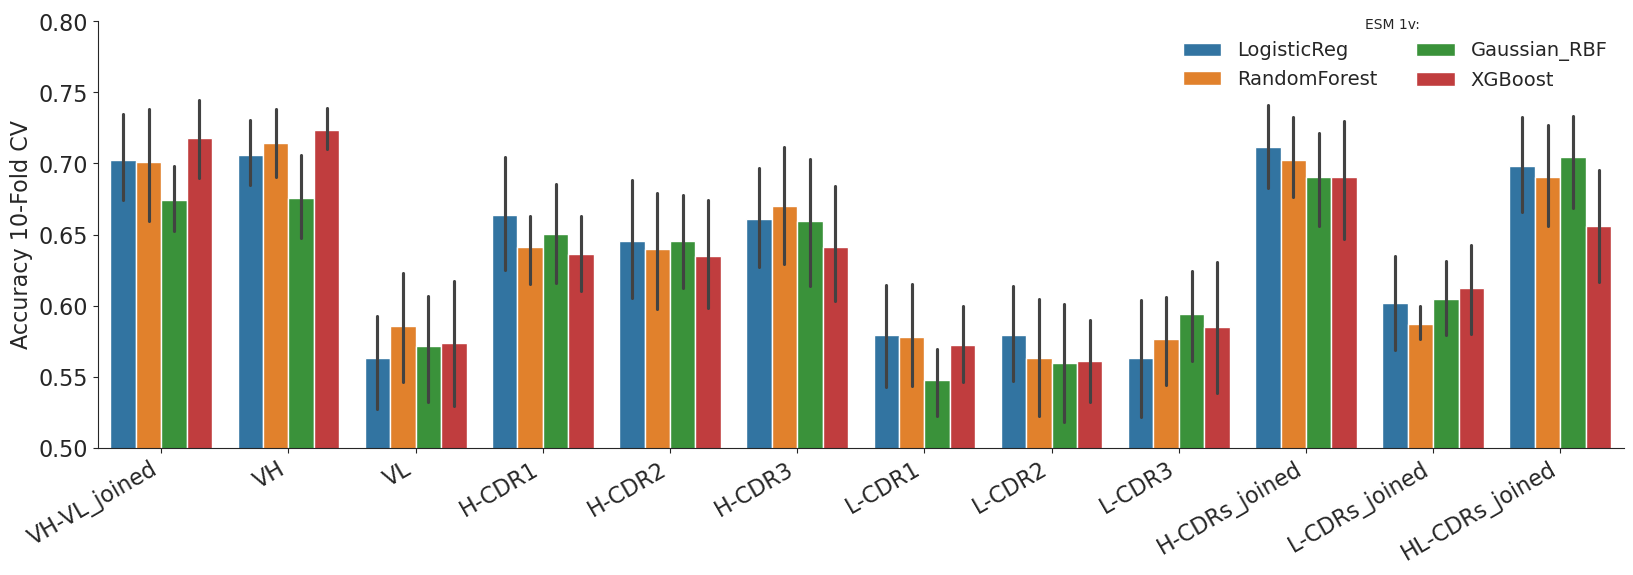

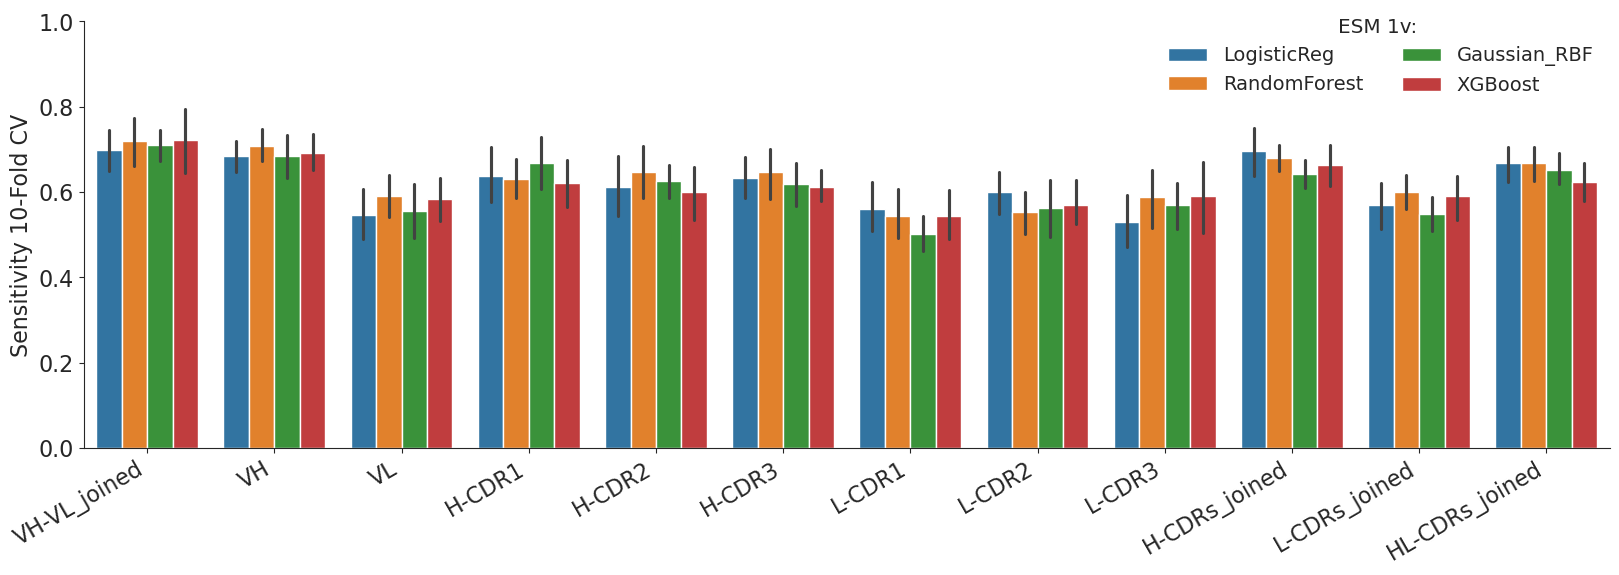

<Figure size 640x480 with 0 Axes>

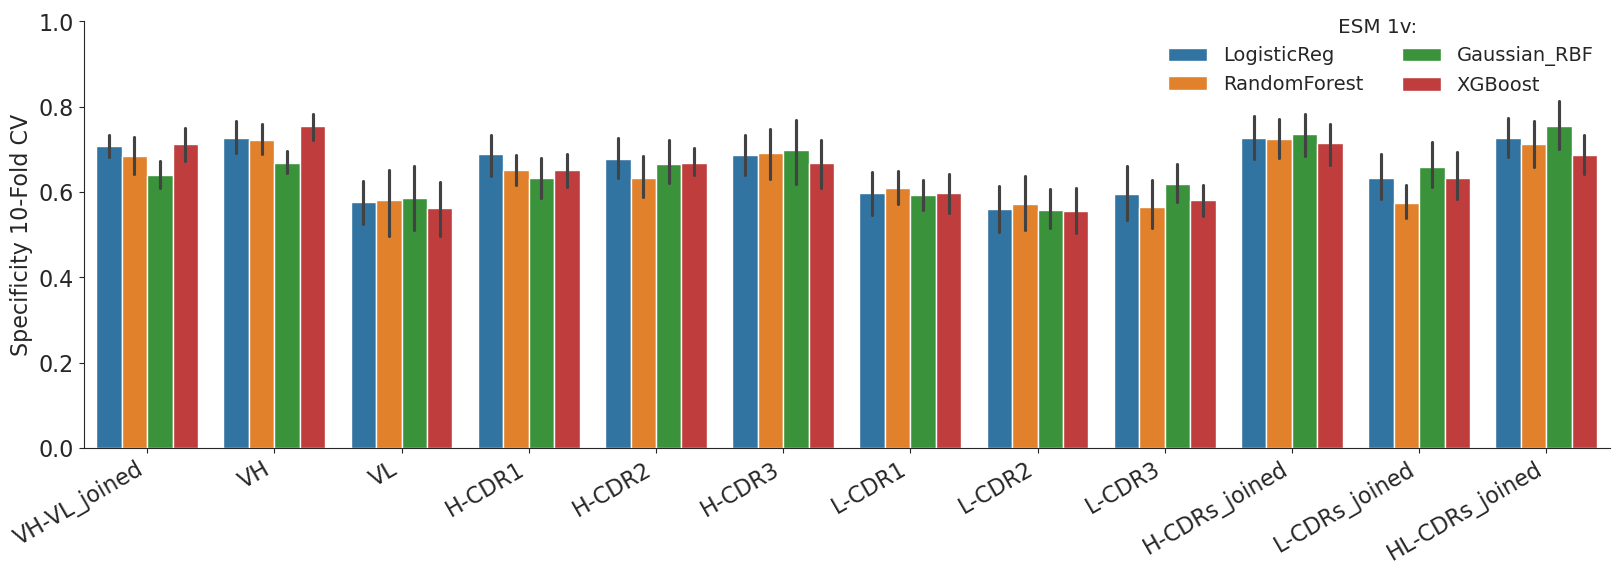

In [12]:
y_lim_1 = [0.5,0,0]
y_lim_2 = [0.8,1,1]
for i, y_axis in enumerate(['accuracy','sensitivity','specificity']):
    plt.figure(1)
    sns.set_style('ticks')
    sns.set_palette(sns.color_palette('tab10'))
    g1 =sns.catplot(data=table_2classes_10CV[(table_2classes_10CV['emd']=='esm1v')],
                    x='seq', 
                    y=y_axis,
                    kind='bar', 
                    hue='model',
                    hue_order= ['LogisticReg','RandomForest','Gaussian_RBF','XGBoost'],
                    order=['VH-VL_joined','VH','VL','H-CDR1','H-CDR2','H-CDR3','L-CDR1','L-CDR2','L-CDR3','H-CDRs_joined','L-CDRs_joined','HL-CDRs_joined'],
                    legend_out=False,
                    )

    plt.xticks(rotation=30,ha='right',fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylim(y_lim_1[i],y_lim_2[i])
    #plt.title('ESM 1v',fontsize=16)
    plt.legend(title='ESM 1v: ',loc="upper center", bbox_to_anchor=(0.85, 1.05), ncol=2,frameon=False,borderaxespad=0.5,fontsize=14)
    plt.rcParams['legend.title_fontsize'] = 'x-large'
    g1.fig.set_figwidth(20)
    g1.fig.set_figheight(5)

    if y_axis == 'sensitivity':
        plt.ylabel('Sensitivity 10-Fold CV',fontsize=16)
    else:
        plt.ylabel(y_axis.capitalize() +' 10-Fold CV',fontsize=16)
    plt.xlabel('')
    plt.savefig('./Figures/Fig1D_10Fold_CV_'+y_axis+'_ESM1v_top_models.pdf',dpi=300, bbox_inches='tight')



### ESM 1b:

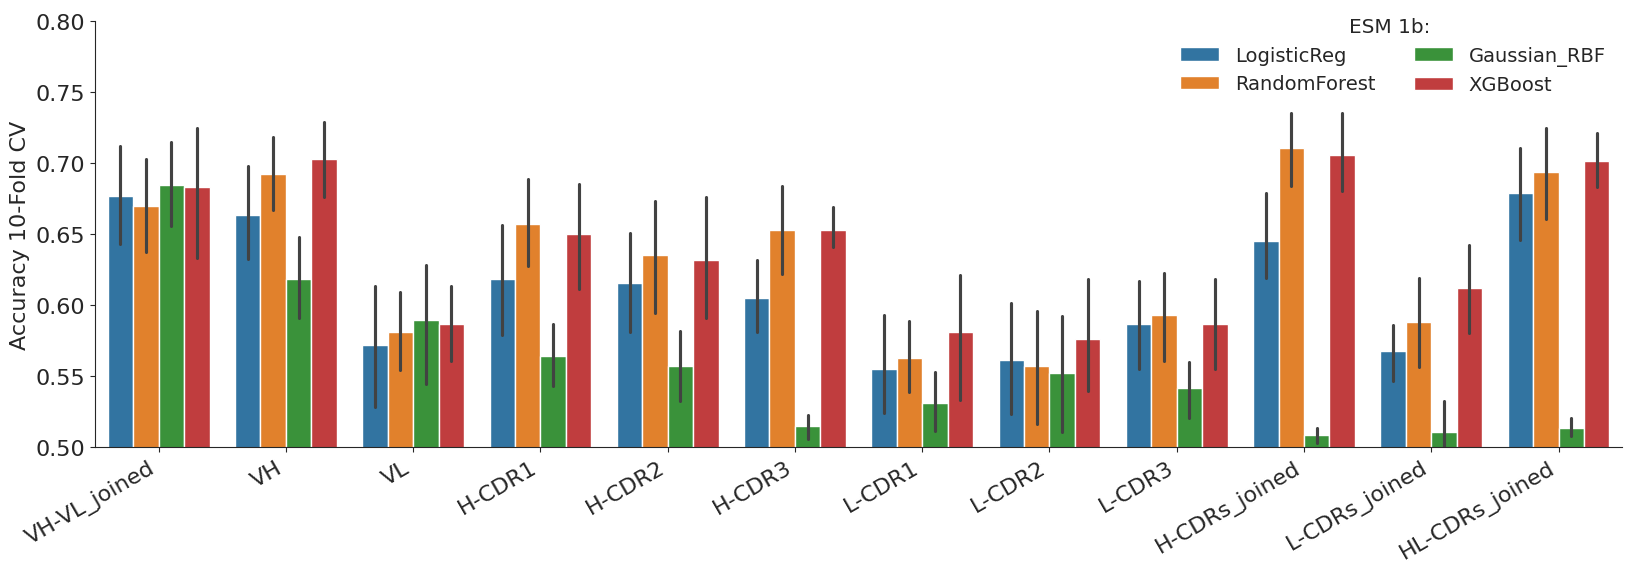

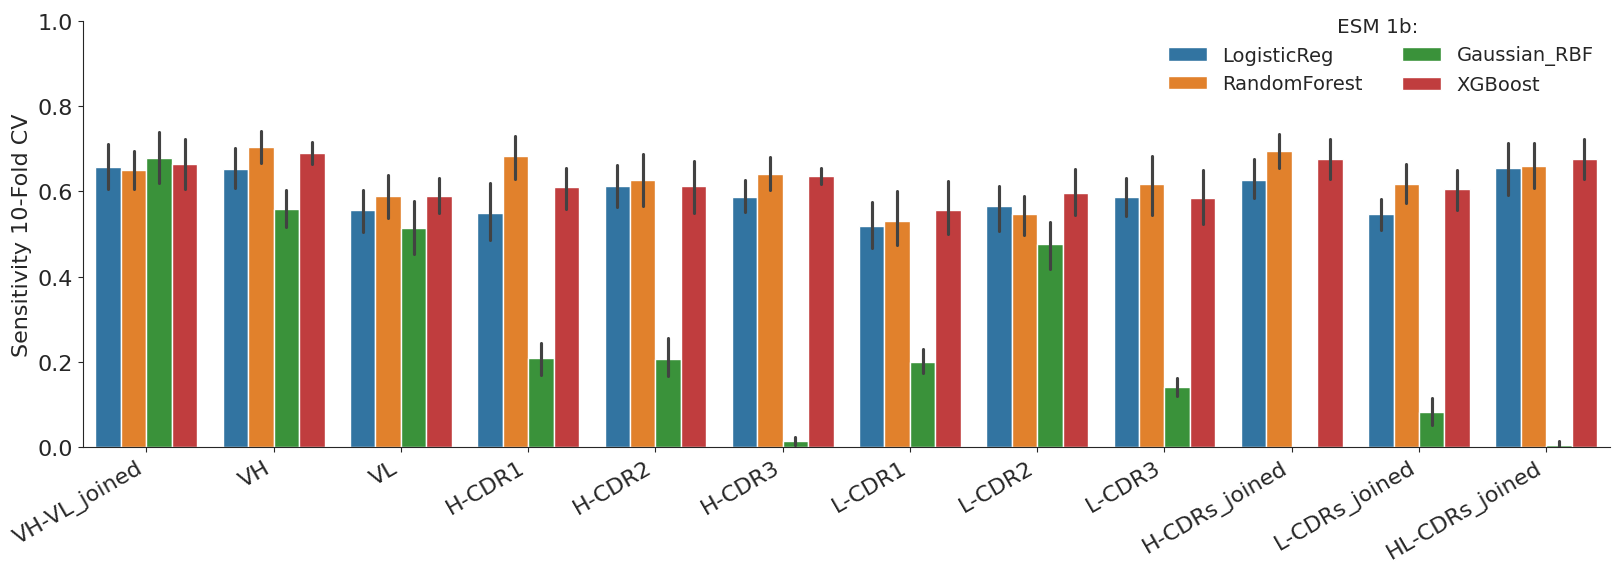

<Figure size 640x480 with 0 Axes>

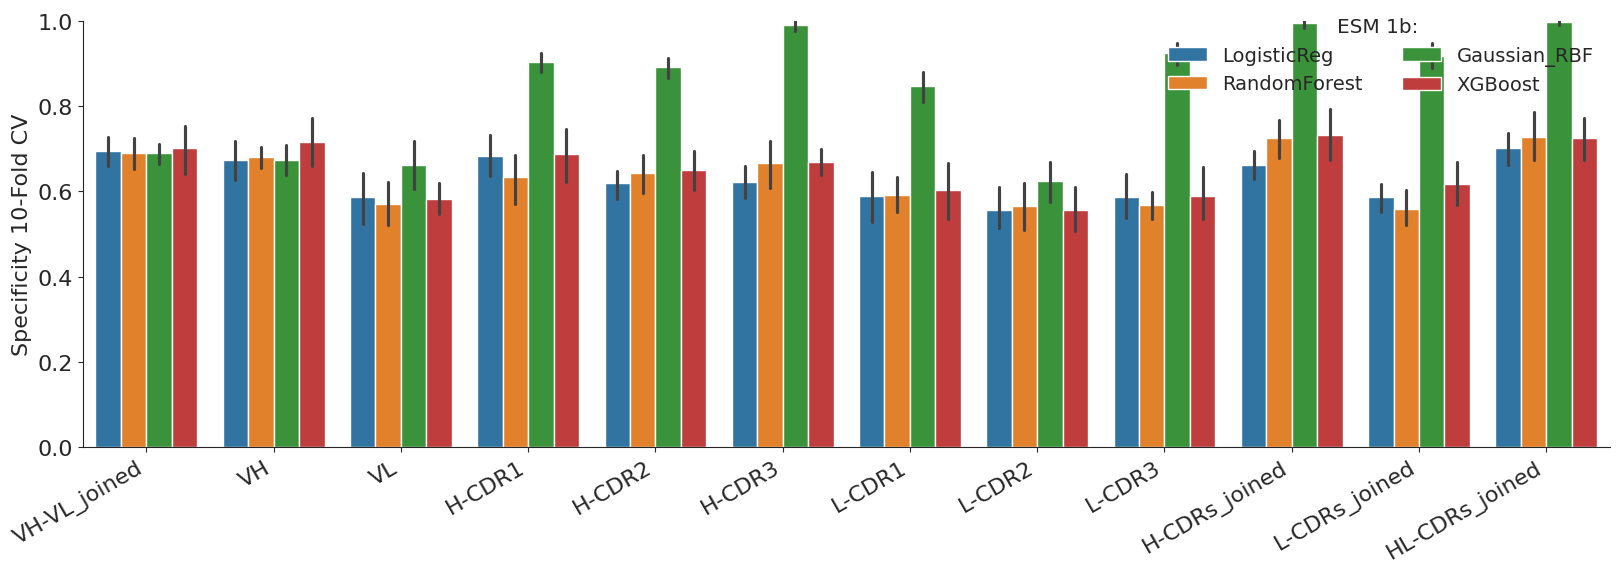

In [142]:
y_lim_1 = [0.5,0,0]
y_lim_2 = [0.8,1,1]
for i, y_axis in enumerate(['accuracy','sensitivity','specificity']):

    plt.figure(1)
    sns.set_style('ticks')
    sns.set_palette(sns.color_palette('tab10'))
    g1 =sns.catplot(data=table_2classes_10CV[(table_2classes_10CV['emd']=='esm1b')],
                    x='seq', 
                    y=y_axis,
                    kind='bar', 
                    hue='model',
                    hue_order= ['LogisticReg','RandomForest','Gaussian_RBF','XGBoost'],
                    order=['VH-VL_joined','VH','VL','H-CDR1','H-CDR2','H-CDR3','L-CDR1','L-CDR2','L-CDR3','H-CDRs_joined','L-CDRs_joined','HL-CDRs_joined'],
                    legend_out=False,
                    )

    plt.xticks(rotation=30,ha='right',fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylim(y_lim_1[i],y_lim_2[i])
    #plt.title('ESM 1b mean-mode',fontsize=16)
    plt.legend(title='ESM 1b: ',loc="upper center", bbox_to_anchor=(0.85, 1.05), ncol=2,frameon=False,borderaxespad=0.5,fontsize=14)
    plt.rcParams['legend.title_fontsize'] = 'x-large'
    g1.fig.set_figwidth(20)
    g1.fig.set_figheight(5)

    if y_axis == 'sensitivity':
        plt.ylabel('Sensitivity 10-Fold CV',fontsize=16)
    else:
        plt.ylabel(y_axis.capitalize() +' 10-Fold CV',fontsize=16)
    plt.xlabel('')
    #plt.savefig('./Figures/SI/10Fold_CV_'+y_axis+'_ESM1b_top_models.pdf',dpi=300, bbox_inches='tight')

### ESM 2:

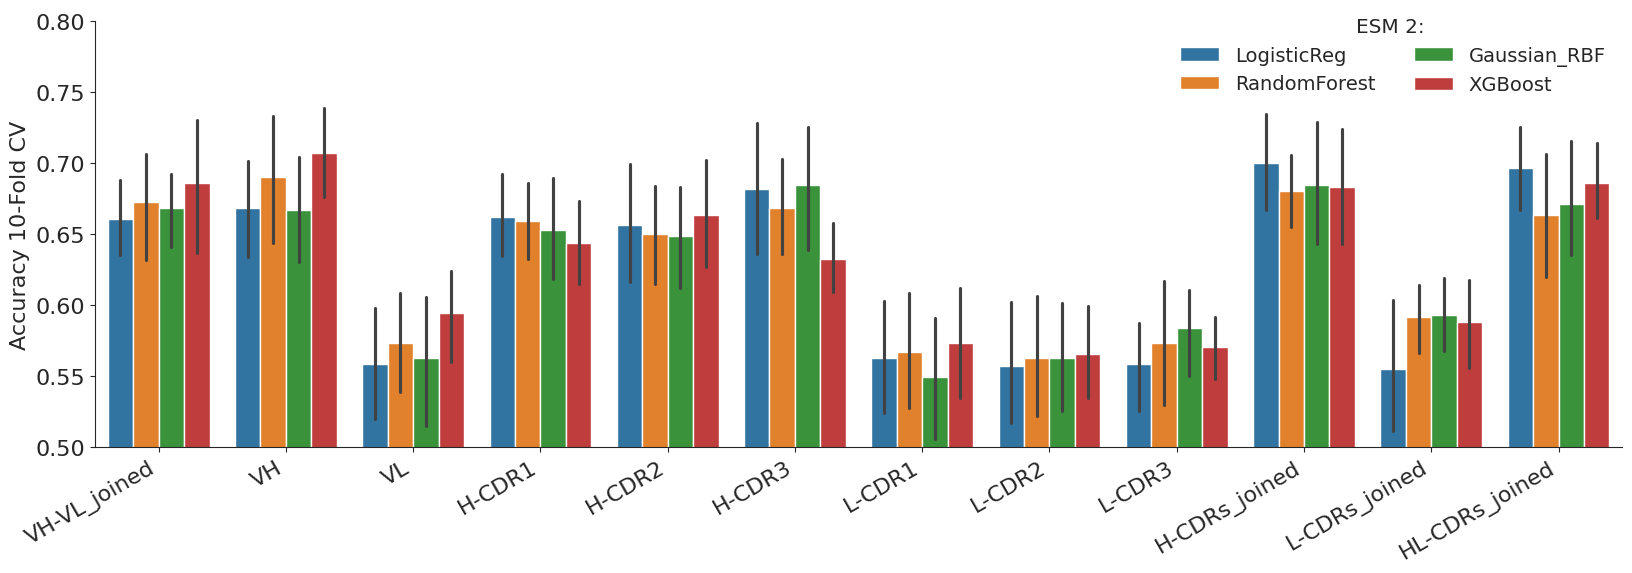

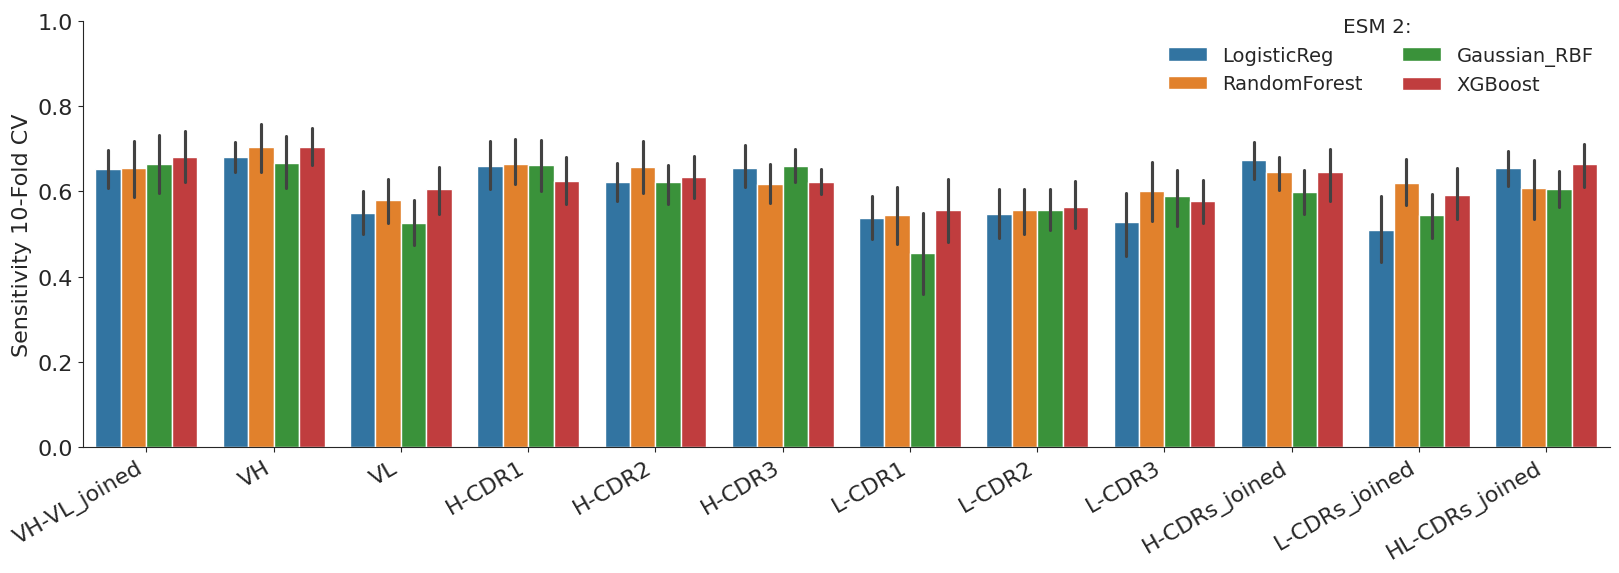

<Figure size 640x480 with 0 Axes>

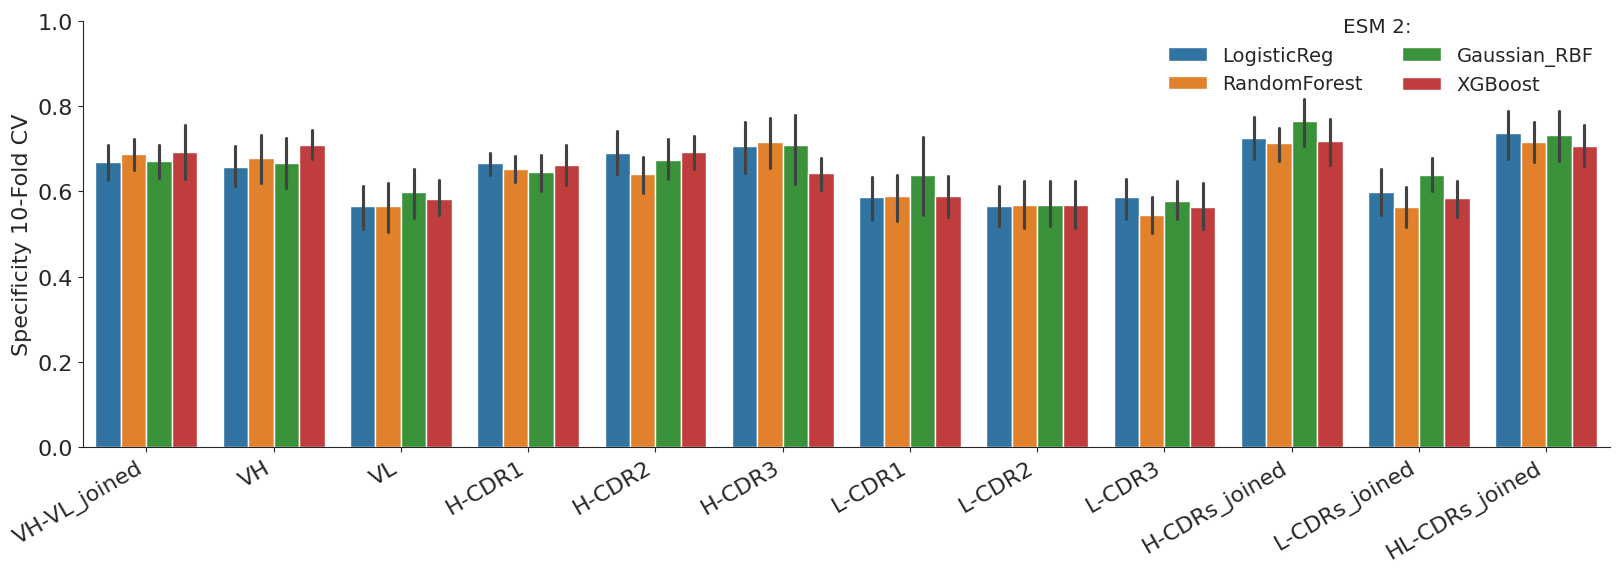

In [143]:
y_lim_1 = [0.5,0,0]
y_lim_2 = [0.8,1,1]
for i, y_axis in enumerate(['accuracy','sensitivity','specificity']):
    
    plt.figure(1)
    sns.set_style('ticks')
    sns.set_palette(sns.color_palette('tab10'))
    g1 =sns.catplot(data=table_2classes_10CV[(table_2classes_10CV['emd']=='esm2')],
                    x='seq', 
                    y=y_axis,
                    kind='bar', 
                    hue='model',
                    hue_order= ['LogisticReg','RandomForest','Gaussian_RBF','XGBoost'],
                    order=['VH-VL_joined','VH','VL','H-CDR1','H-CDR2','H-CDR3','L-CDR1','L-CDR2','L-CDR3','H-CDRs_joined','L-CDRs_joined','HL-CDRs_joined'],
                    legend_out=False,
                    )

    plt.xticks(rotation=30,ha='right',fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylim(y_lim_1[i],y_lim_2[i])
    #plt.title('ESM 2 mean-mode',fontsize=16)
    plt.legend(title='ESM 2: ',loc="upper center", bbox_to_anchor=(0.85, 1.05), ncol=2,frameon=False,borderaxespad=0.5,fontsize=14)
    plt.rcParams['legend.title_fontsize'] = 'x-large'
    g1.fig.set_figwidth(20)
    g1.fig.set_figheight(5)

    if y_axis == 'sensitivity':
        plt.ylabel('Sensitivity 10-Fold CV',fontsize=16)
    else:
        plt.ylabel(y_axis.capitalize() +' 10-Fold CV',fontsize=16)
    plt.xlabel('')
    #plt.savefig('./Figures/SI/10Fold_CV_'+y_axis+'_ESM2_top_models.pdf',dpi=300, bbox_inches='tight')


### Protbert bfd:

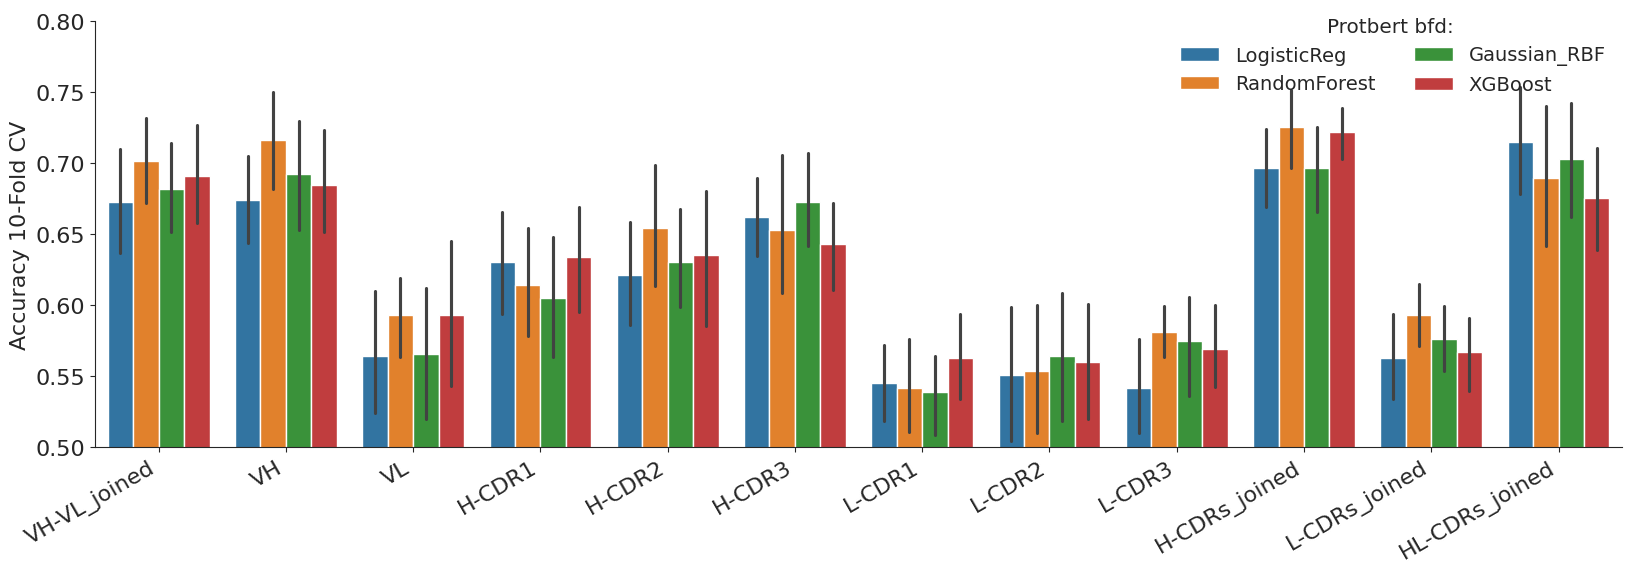

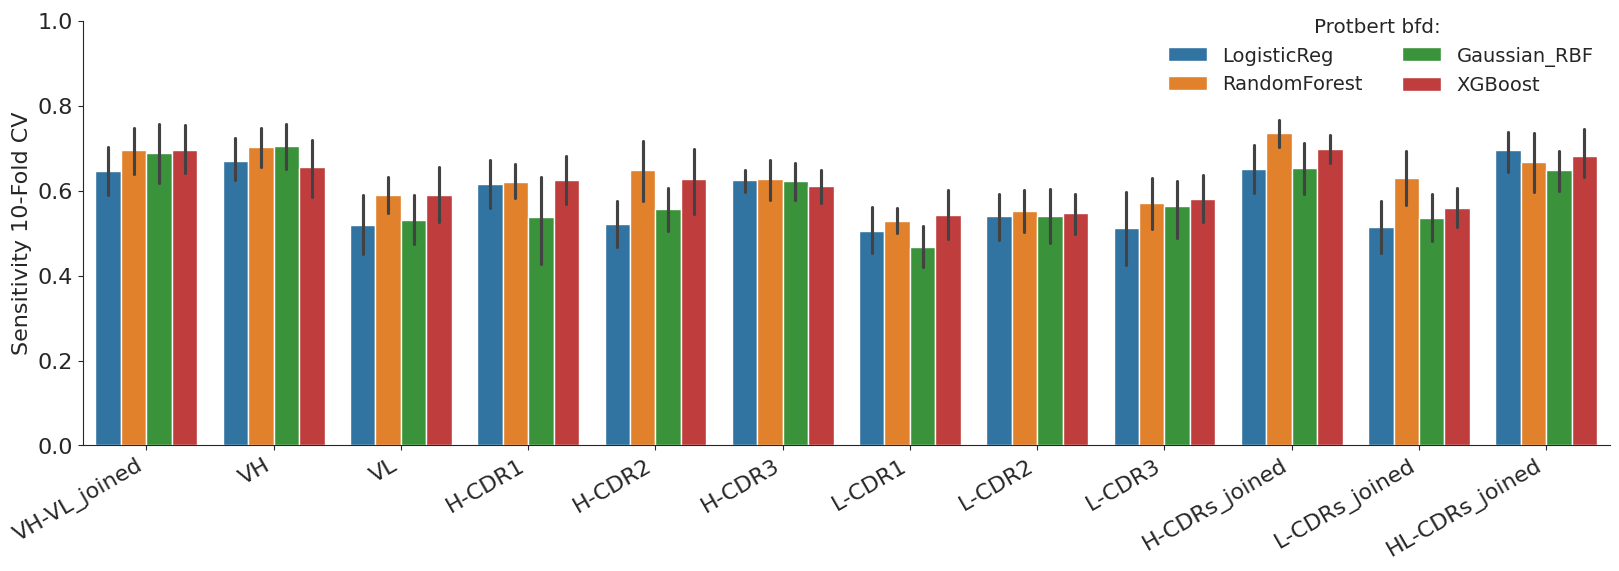

<Figure size 640x480 with 0 Axes>

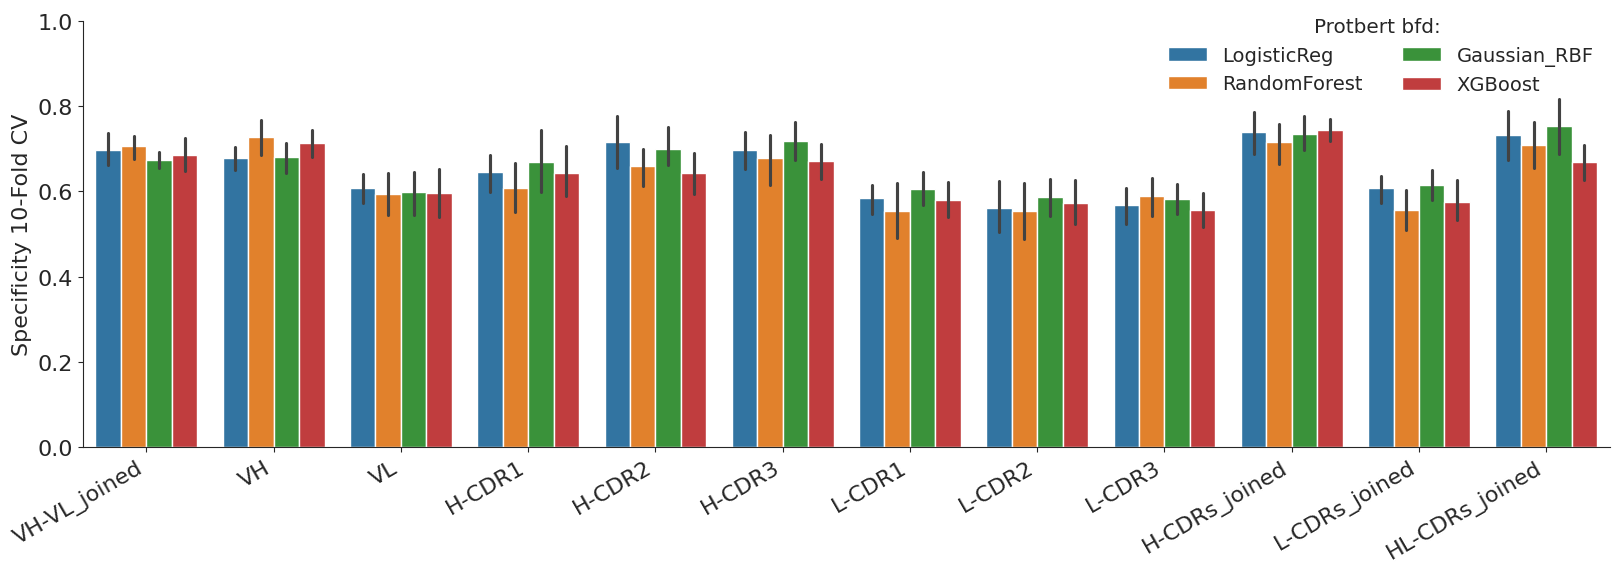

In [144]:
y_lim_1 = [0.5,0,0]
y_lim_2 = [0.8,1,1]
for i, y_axis in enumerate(['accuracy','sensitivity','specificity']):

    plt.figure(1)
    sns.set_style('ticks')
    sns.set_palette(sns.color_palette('tab10'))
    g1 =sns.catplot(data=table_2classes_10CV[(table_2classes_10CV['emd']=='protbert_bfd')],
                    x='seq', 
                    y=y_axis,
                    kind='bar', 
                    hue='model',
                    hue_order= ['LogisticReg','RandomForest','Gaussian_RBF','XGBoost'],
                    order=['VH-VL_joined','VH','VL','H-CDR1','H-CDR2','H-CDR3','L-CDR1','L-CDR2','L-CDR3','H-CDRs_joined','L-CDRs_joined','HL-CDRs_joined'],
                    legend_out=False,
                    )

    plt.xticks(rotation=30,ha='right',fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylim(y_lim_1[i],y_lim_2[i])
    #plt.title('Protbert_bfd mean-mode',fontsize=16)
    plt.legend(title='Protbert bfd: ',loc="upper center", bbox_to_anchor=(0.85, 1.05), ncol=2,frameon=False,borderaxespad=0.5,fontsize=14)
    plt.rcParams['legend.title_fontsize'] = 'x-large'
    g1.fig.set_figwidth(20)
    g1.fig.set_figheight(5)

    if y_axis == 'sensitivity':
        plt.ylabel('Sensitivity 10-Fold CV',fontsize=16)
    else:
        plt.ylabel(y_axis.capitalize() +' 10-Fold CV',fontsize=16)
    plt.xlabel('')
    #plt.savefig('./Figures/SI/10Fold_CV_'+y_axis+'_Protbert_bfd_top_models.pdf',dpi=300, bbox_inches='tight')


### AntiBERTy:

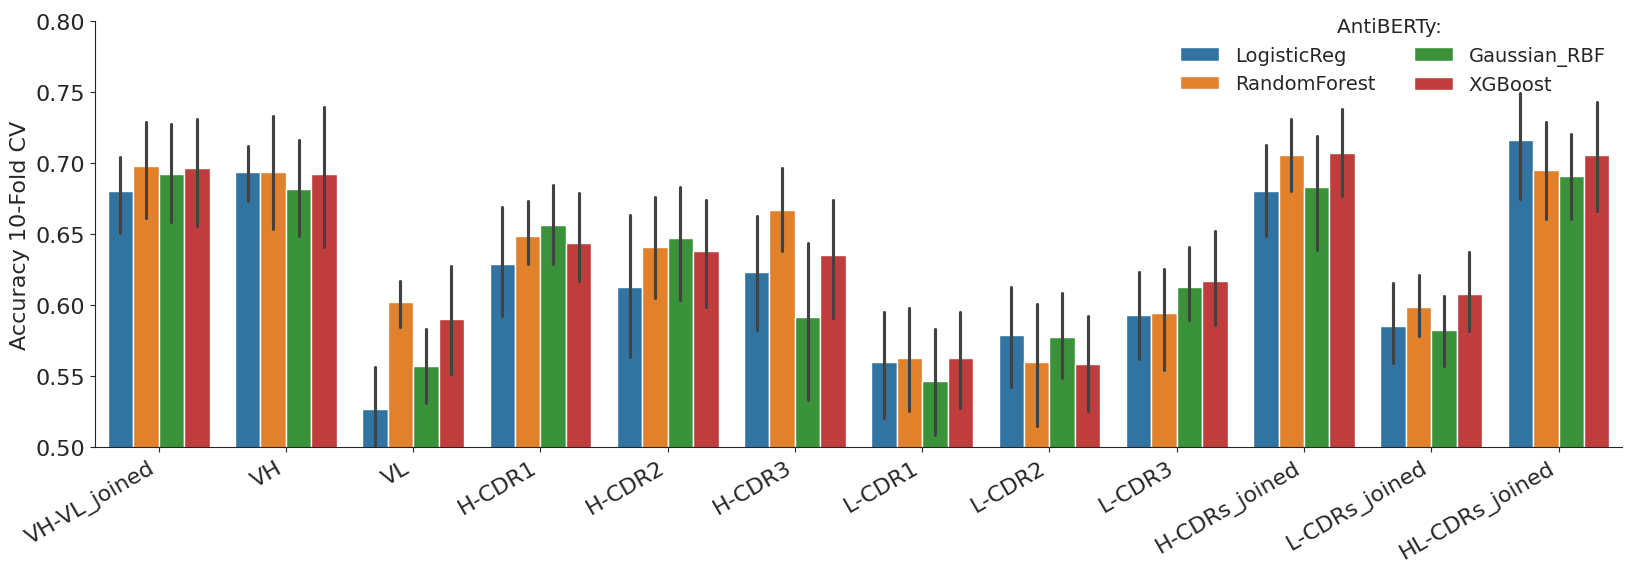

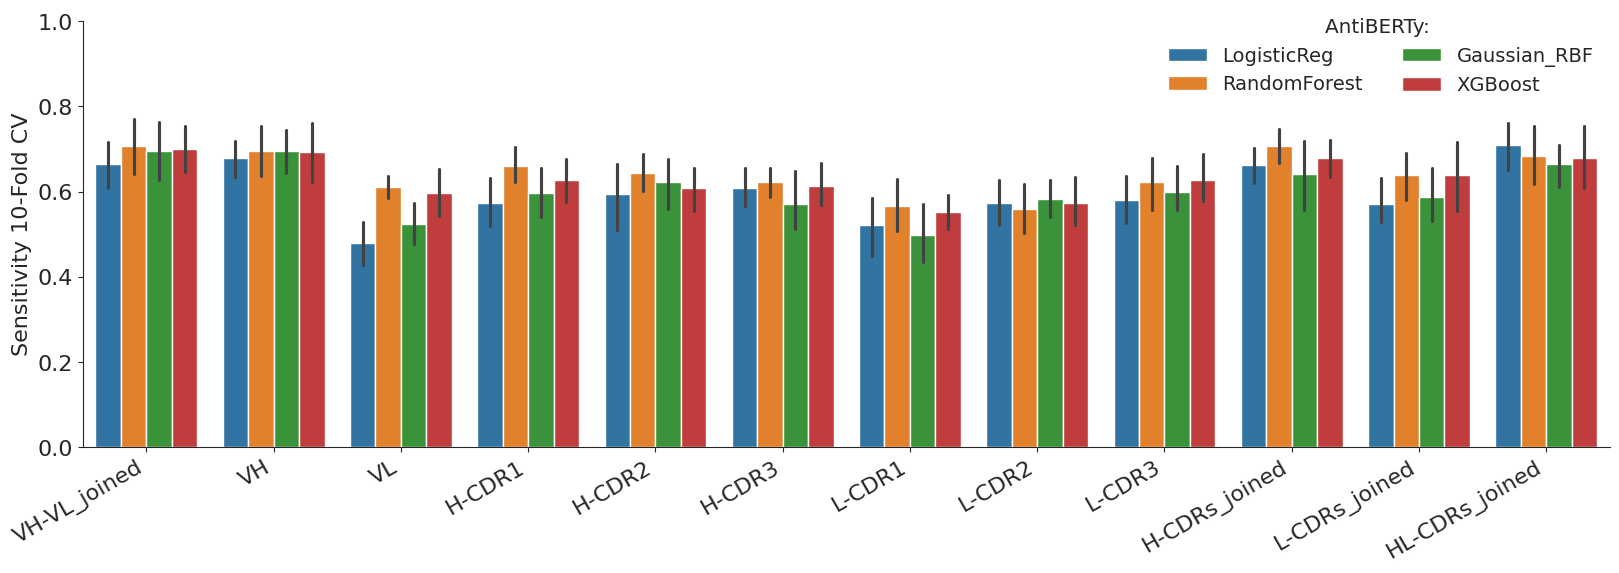

<Figure size 640x480 with 0 Axes>

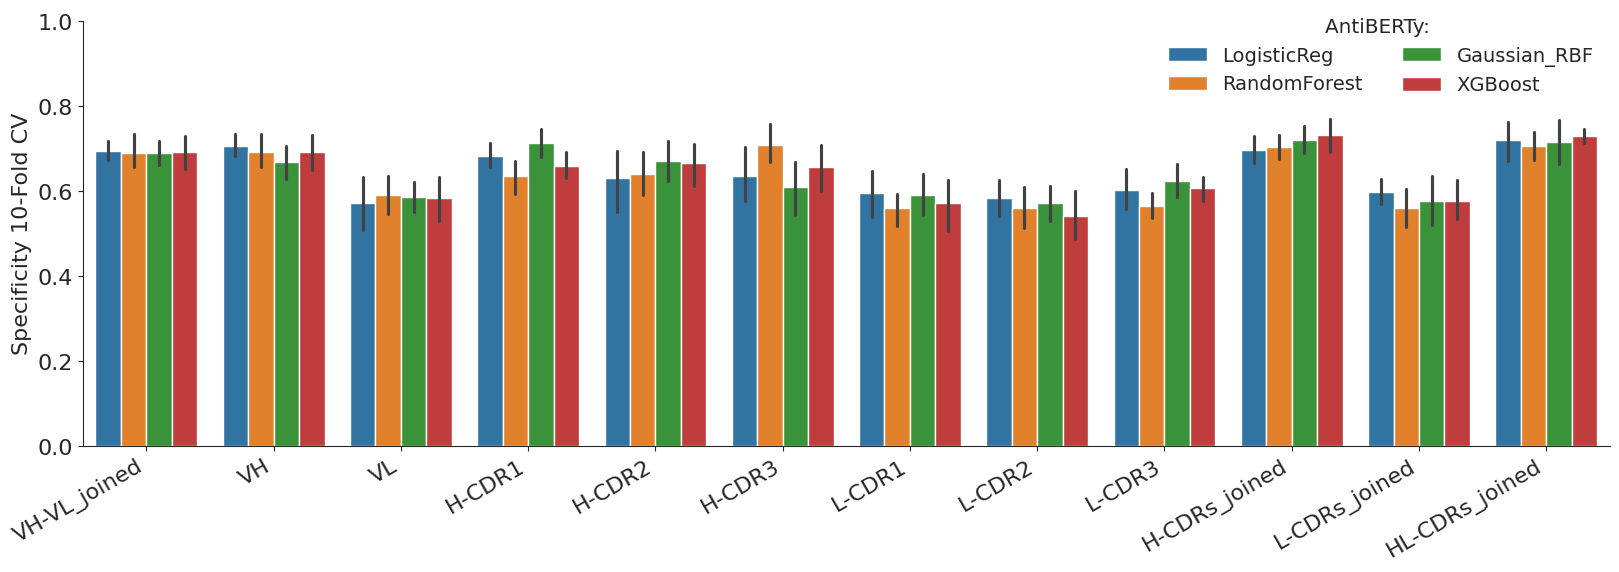

In [145]:
y_lim_1 = [0.5,0,0]
y_lim_2 = [0.8,1,1]
for i, y_axis in enumerate(['accuracy','sensitivity','specificity']):

    plt.figure(1)
    sns.set_style('ticks')
    sns.set_palette(sns.color_palette('tab10'))
    g1 =sns.catplot(data=table_2classes_10CV[(table_2classes_10CV['emd']=='AntiBERTy')],
                    x='seq', 
                    y=y_axis,
                    kind='bar', 
                    hue='model',
                    hue_order= ['LogisticReg','RandomForest','Gaussian_RBF','XGBoost'],
                    order=['VH-VL_joined','VH','VL','H-CDR1','H-CDR2','H-CDR3','L-CDR1','L-CDR2','L-CDR3','H-CDRs_joined','L-CDRs_joined','HL-CDRs_joined'],
                    legend_out=False,
                    )

    plt.xticks(rotation=30,ha='right',fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylim(y_lim_1[i],y_lim_2[i])
    #plt.title('AntiBERTy mean-mode',fontsize=16)
    plt.legend(title='AntiBERTy: ',loc="upper center", bbox_to_anchor=(0.85, 1.05), ncol=2,frameon=False,borderaxespad=0.5,fontsize=14)
    plt.rcParams['legend.title_fontsize'] = 'x-large'
    g1.fig.set_figwidth(20)
    g1.fig.set_figheight(5)

    if y_axis == 'sensitivity':
        plt.ylabel('Sensitivity 10-Fold CV',fontsize=16)
    else:
        plt.ylabel(y_axis.capitalize() +' 10-Fold CV',fontsize=16)
    plt.xlabel('')
    #plt.savefig('./Figures/SI/10Fold_CV_'+y_axis+'_AntiBERTy_top_models.pdf',dpi=300, bbox_inches='tight')

### All descriptors:

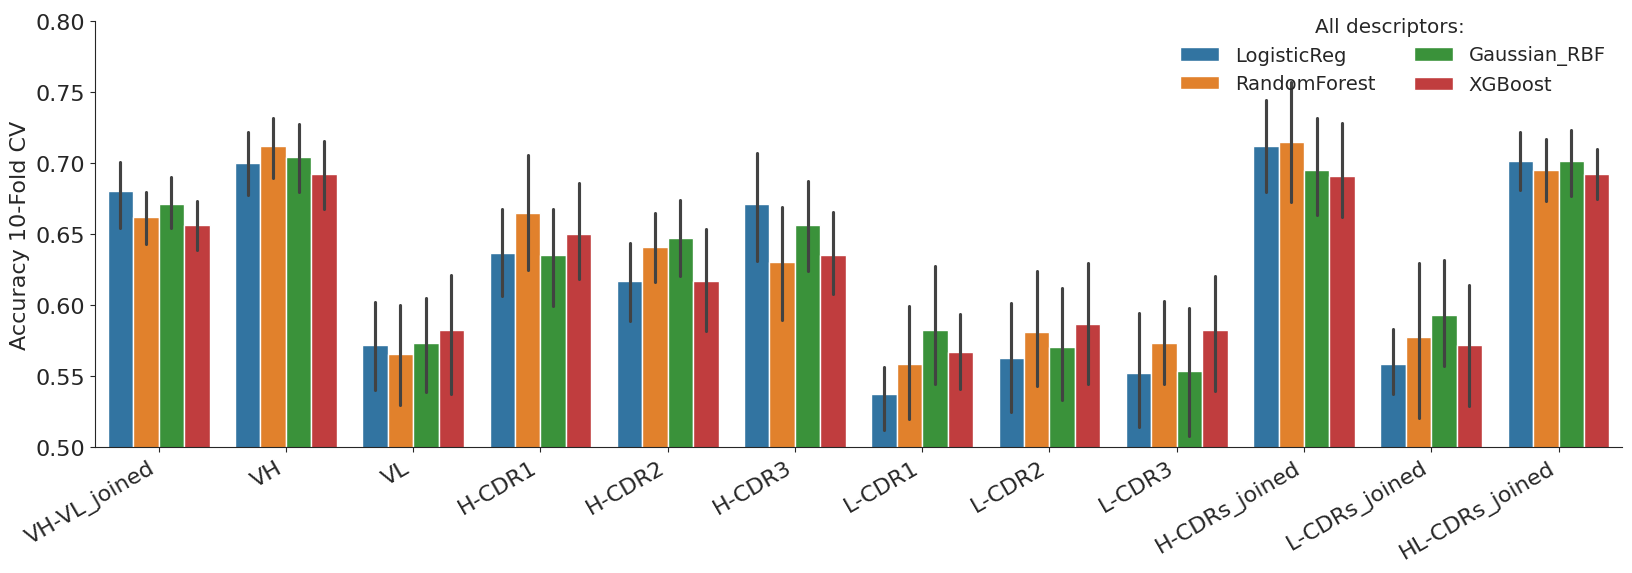

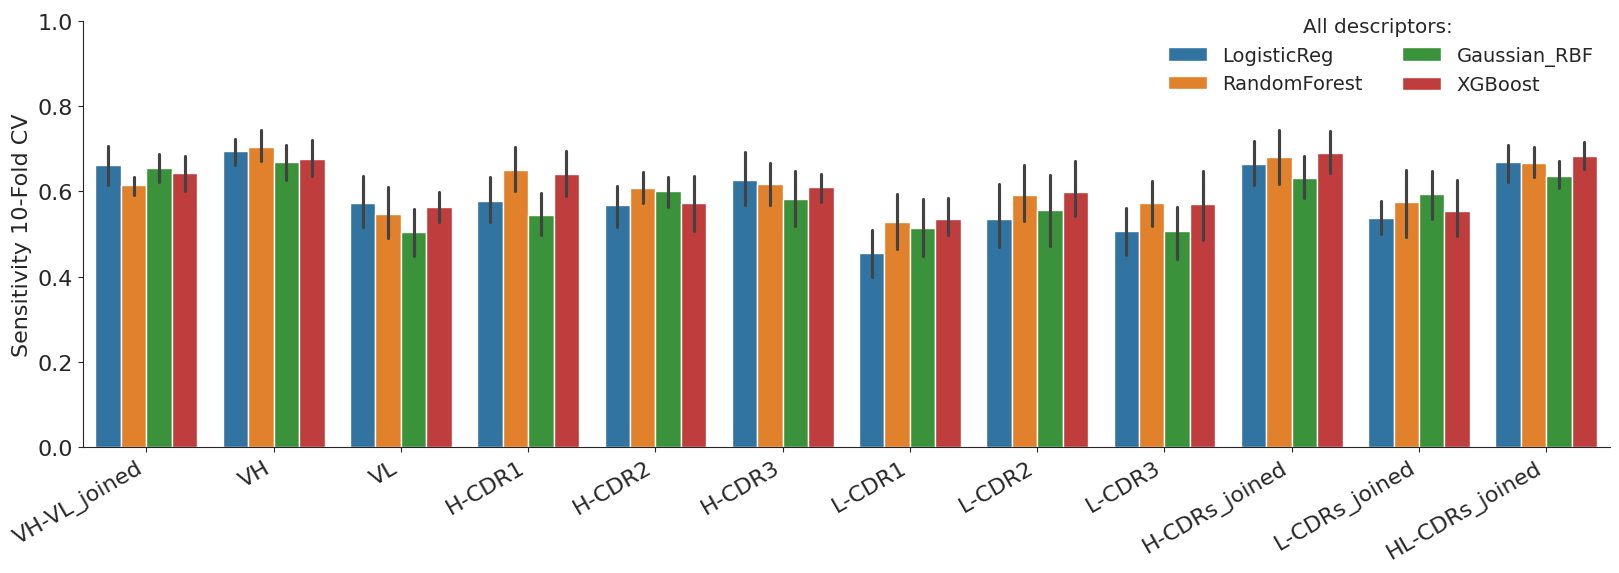

<Figure size 640x480 with 0 Axes>

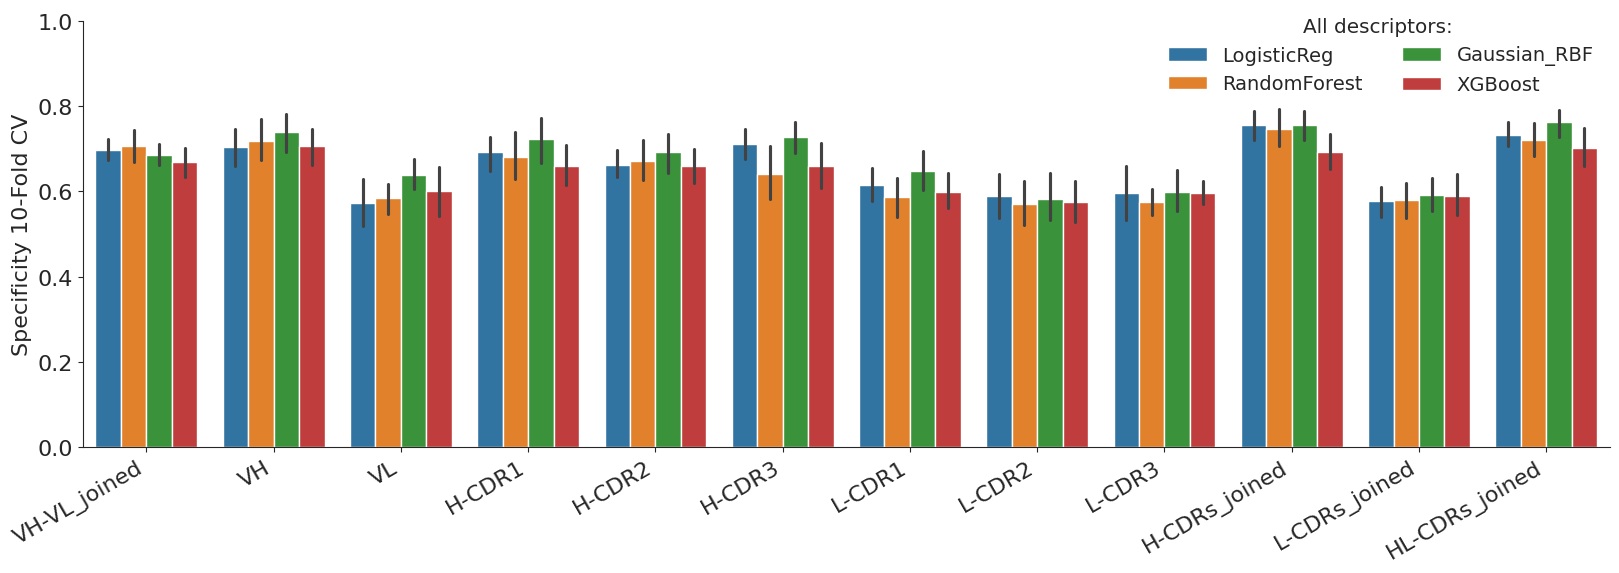

In [151]:
y_lim_1 = [0.5,0,0]
y_lim_2 = [0.8,1,1]
for i, y_axis in enumerate(['accuracy','sensitivity','specificity']):

    plt.figure(1)
    sns.set_style('ticks')
    sns.set_palette(sns.color_palette('tab10'))
    g1 =sns.catplot(data=table_2classes_10CV[(table_2classes_10CV['emd']=='desc_all')],
                    x='seq', 
                    y=y_axis,
                    kind='bar', 
                    hue='model',
                    hue_order= ['LogisticReg','RandomForest','Gaussian_RBF','XGBoost'],
                    order=['VH-VL_joined','VH','VL','H-CDR1','H-CDR2','H-CDR3','L-CDR1','L-CDR2','L-CDR3','H-CDRs_joined','L-CDRs_joined','HL-CDRs_joined'],
                    legend_out=False,
                    )

    plt.xticks(rotation=30,ha='right',fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylim(y_lim_1[i],y_lim_2[i])
    #plt.title('Descriptors',fontsize=16)
    plt.legend(title='All descriptors: ',loc="upper center", bbox_to_anchor=(0.85, 1.05), ncol=2,frameon=False,borderaxespad=0.5,fontsize=14)
    plt.rcParams['legend.title_fontsize'] = 'x-large'
    g1.fig.set_figwidth(20)
    g1.fig.set_figheight(5)

    if y_axis == 'sensitivity':
        plt.ylabel('Sensitivity 10-Fold CV',fontsize=16)
    else:
        plt.ylabel(y_axis.capitalize() +' 10-Fold CV',fontsize=16)
    plt.xlabel('')
    #plt.savefig('./Figures/SI/10Fold_CV_'+y_axis+'_Descriptors_top_models.pdf',dpi=300, bbox_inches='tight')

### Top 5 descriptors:

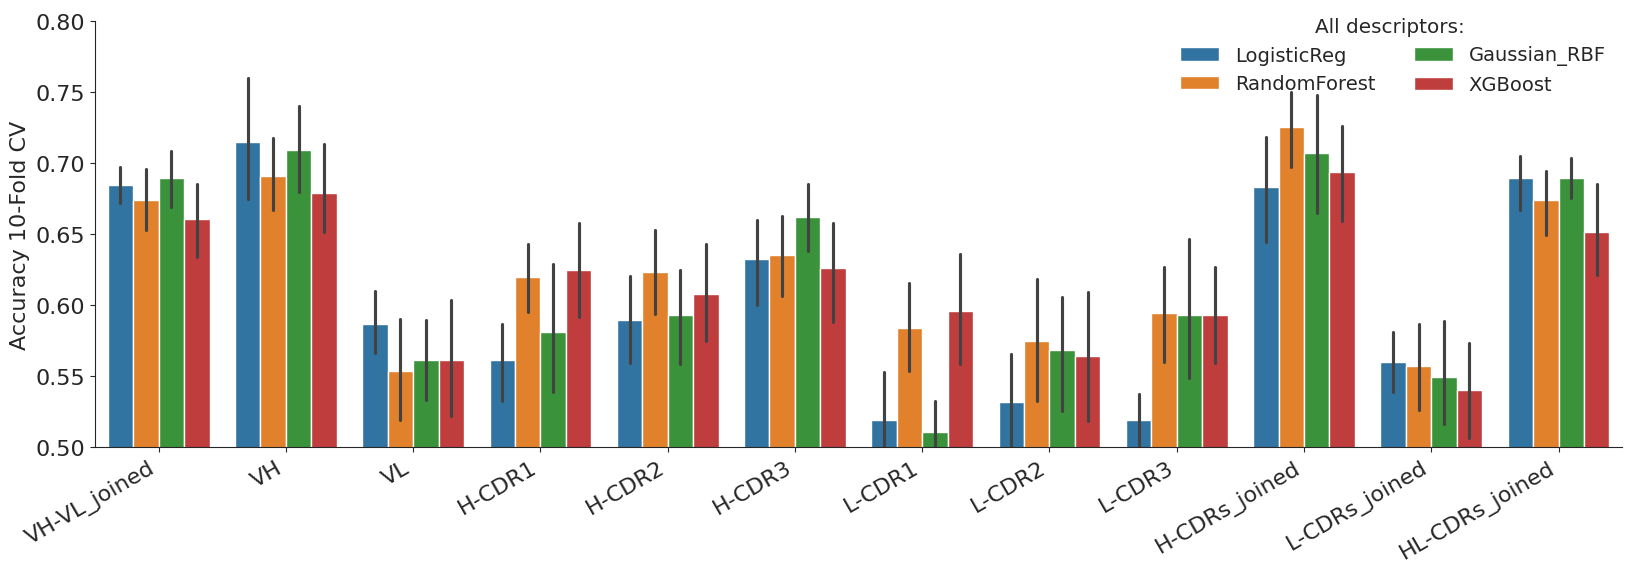

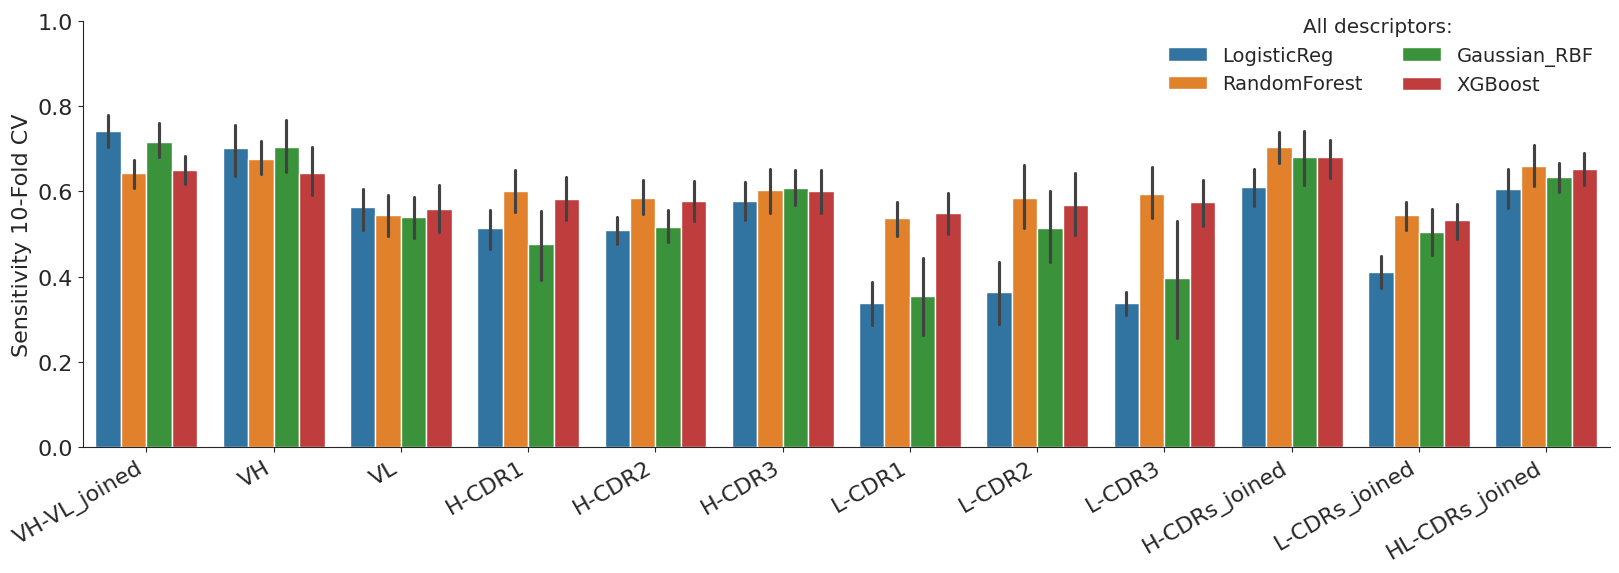

<Figure size 640x480 with 0 Axes>

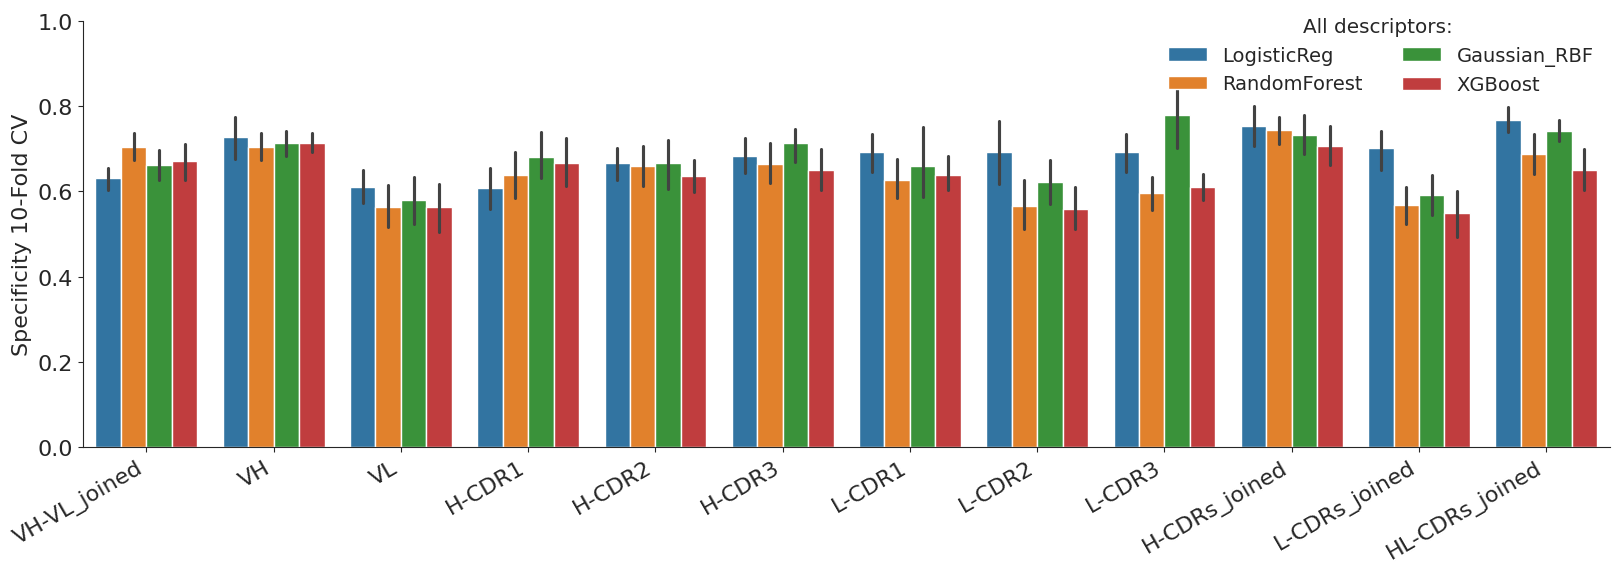

In [152]:
y_lim_1 = [0.5,0,0]
y_lim_2 = [0.8,1,1]
for i, y_axis in enumerate(['accuracy','sensitivity','specificity']):

    plt.figure(1)
    sns.set_style('ticks')
    sns.set_palette(sns.color_palette('tab10'))
    g1 =sns.catplot(data=table_2classes_10CV[(table_2classes_10CV['emd']=='desc_top5')],
                    x='seq', 
                    y=y_axis,
                    kind='bar', 
                    hue='model',
                    hue_order= ['LogisticReg','RandomForest','Gaussian_RBF','XGBoost'],
                    order=['VH-VL_joined','VH','VL','H-CDR1','H-CDR2','H-CDR3','L-CDR1','L-CDR2','L-CDR3','H-CDRs_joined','L-CDRs_joined','HL-CDRs_joined'],
                    legend_out=False,
                    )

    plt.xticks(rotation=30,ha='right',fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylim(y_lim_1[i],y_lim_2[i])
    #plt.title('Descriptors',fontsize=16)
    plt.legend(title='All descriptors: ',loc="upper center", bbox_to_anchor=(0.85, 1.05), ncol=2,frameon=False,borderaxespad=0.5,fontsize=14)
    plt.rcParams['legend.title_fontsize'] = 'x-large'
    g1.fig.set_figwidth(20)
    g1.fig.set_figheight(5)

    if y_axis == 'sensitivity':
        plt.ylabel('Sensitivity 10-Fold CV',fontsize=16)
    else:
        plt.ylabel(y_axis.capitalize() +' 10-Fold CV',fontsize=16)
    plt.xlabel('')
    #plt.savefig('./Figures/SI/10Fold_CV_'+y_axis+'_Descriptors_top5_models.pdf',dpi=300, bbox_inches='tight')

## (2) Validation performances (k-fold and Leave-One Family-Out):

### PLM models:

<Figure size 640x480 with 0 Axes>

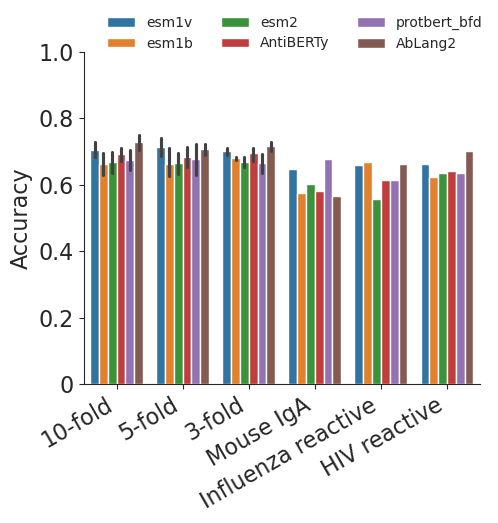

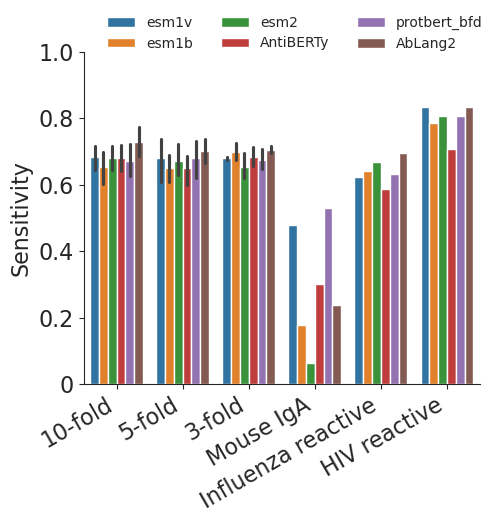

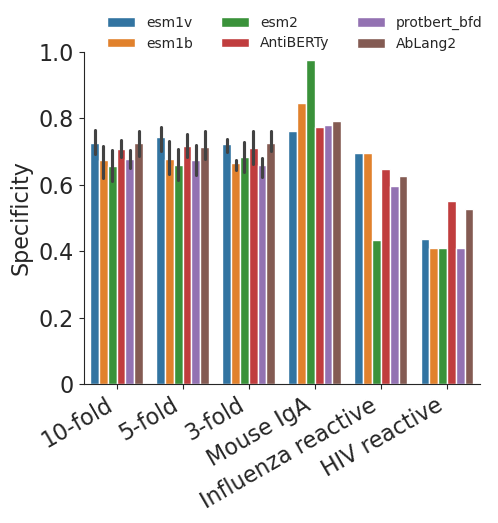

In [13]:
# --- Bar plot of validation performances (k-fold and leave-one-family-out):

font = 16

# Add 'type' column:
table_2classes_3CV['type'] = list(table_2classes_3CV['CV'])
table_2classes_5CV['type'] = list(table_2classes_5CV['CV'])
table_2classes_10CV['type'] = list(table_2classes_10CV['CV'])
table_2classes_2families['type'] = list(table_2classes_2families['test Ab type'])


# Concat:
table_2classes_concat = pd.concat([table_2classes_10CV,
                                   table_2classes_5CV,
                                   table_2classes_3CV,
                                   table_2classes_2families])


plt.figure(1)
sns.set_style('ticks')
sns.set_palette(sns.color_palette('tab10'))
s = sns.catplot(x="type", 
                y="accuracy", 
                hue='emd', #"seq", 
                data=table_2classes_concat[(table_2classes_concat['model']=='LogisticReg') &
                                           (table_2classes_concat['emd'].isin(['esm1v','esm1b','esm2','AntiBERTy','protbert_bfd','AbLang2'])) & 
                                           (table_2classes_concat['seq']=='VH') ],
                 kind="bar",
                 hue_order=['esm1v','esm1b','esm2','AntiBERTy','protbert_bfd','AbLang2'], 
                 legend=True)


plt.xticks(rotation=30,ha='right',fontsize=font)
plt.yticks([0,0.2,0.4,0.6,0.8,1.0],[0,0.2,0.4,0.6,0.8,1.0])
s.set_yticklabels(size=font)
plt.ylim(0,1)
plt.ylabel('Accuracy',fontsize=font)
plt.xlabel('')
sns.move_legend(s, "upper center", bbox_to_anchor=(0.6, 1.05), ncol=3, frameon=False, borderaxespad=0.5,fontsize=10, title='')
s.fig.set_figwidth(5) #5
s.fig.set_figheight(5)
plt.tight_layout()
#plt.savefig('./Figures_publication/Bar plots/Fig1D_VH_LogisticReg_accuracy.pdf',dpi=300, bbox_inches='tight')



plt.figure(2)
sns.set_style('ticks')
sns.set_palette(sns.color_palette('tab10'))
s = sns.catplot(x="type", 
                y="sensitivity", 
                hue="emd", 
                data=table_2classes_concat[(table_2classes_concat['model']=='LogisticReg') &
                                           (table_2classes_concat['emd'].isin(['esm1v','esm1b','esm2','AntiBERTy','protbert_bfd','AbLang2'])) & 
                                           (table_2classes_concat['seq']=='VH') ],
                kind="bar",
                hue_order=['esm1v','esm1b','esm2','AntiBERTy','protbert_bfd','AbLang2'], 
                legend=True)

plt.xticks(rotation=30,ha='right',fontsize=font)
plt.yticks([0,0.2,0.4,0.6,0.8,1.0],[0,0.2,0.4,0.6,0.8,1.0])
s.set_yticklabels(size=font)
plt.ylim(0,1)
plt.ylabel('Sensitivity',fontsize=font) #Sensitivity
plt.xlabel('')
sns.move_legend(s, "upper center", bbox_to_anchor=(0.6, 1.05), ncol=3, frameon=False, borderaxespad=0.5,fontsize=10, title='')
s.fig.set_figwidth(5) #5
s.fig.set_figheight(5)
plt.tight_layout()
#plt.savefig('./Figures_publication/Bar plots/Fig1D_VH_LogisticReg_sensitivity.pdf',dpi=300, bbox_inches='tight')

plt.figure(3)
sns.set_style('ticks')
sns.set_palette(sns.color_palette('tab10'))
s = sns.catplot(x="type", 
                y="specificity", 
                hue="emd", 
                data=table_2classes_concat[(table_2classes_concat['model']=='LogisticReg') &
                                           (table_2classes_concat['emd'].isin(['esm1v','esm1b','esm2','AntiBERTy','protbert_bfd','AbLang2'])) & 
                                           (table_2classes_concat['seq']=='VH') ],
                kind="bar",
                hue_order=['esm1v','esm1b','esm2','AntiBERTy','protbert_bfd','AbLang2'], 
                legend=True)

plt.xticks(rotation=30,ha='right',fontsize=font)
plt.yticks([0,0.2,0.4,0.6,0.8,1.0],[0,0.2,0.4,0.6,0.8,1.0])
s.set_yticklabels(size=font)
plt.ylim(0,1)
plt.ylabel('Specificity',fontsize=font)
plt.xlabel('')
sns.move_legend(s, "upper center", bbox_to_anchor=(0.6, 1.05), ncol=3, frameon=False, borderaxespad=0.5,fontsize=10, title='')
s.fig.set_figwidth(5) #5
s.fig.set_figheight(5)
plt.tight_layout()
plt.savefig('./Figures/Fig1C_VH_LogisticReg_specificity.pdf',dpi=300, bbox_inches='tight')
plt.show()


### Baseline models:

<Figure size 640x480 with 0 Axes>

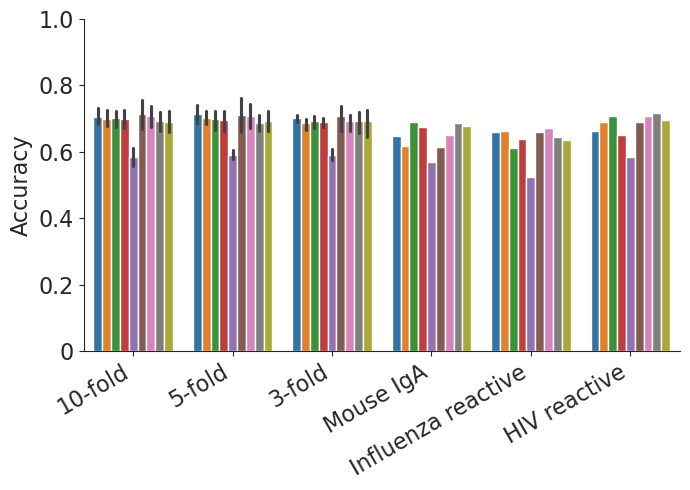

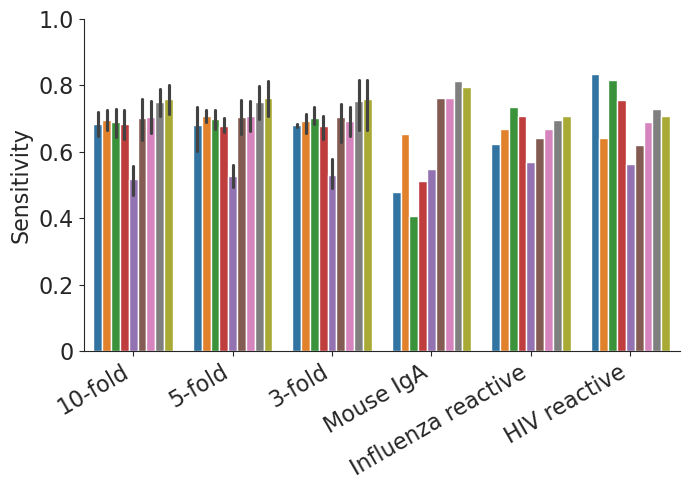

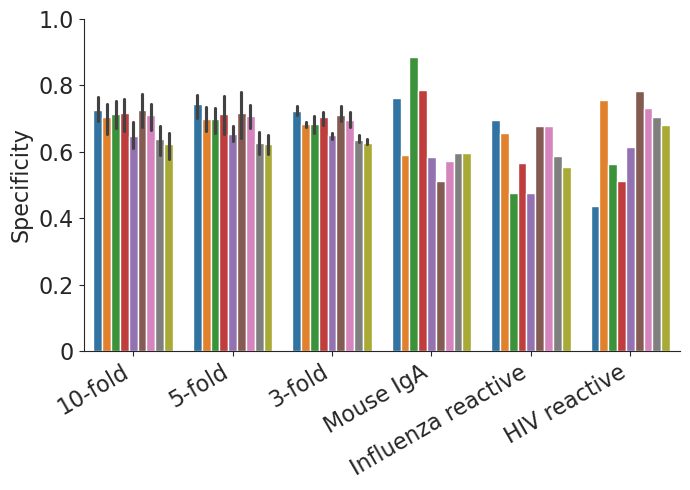

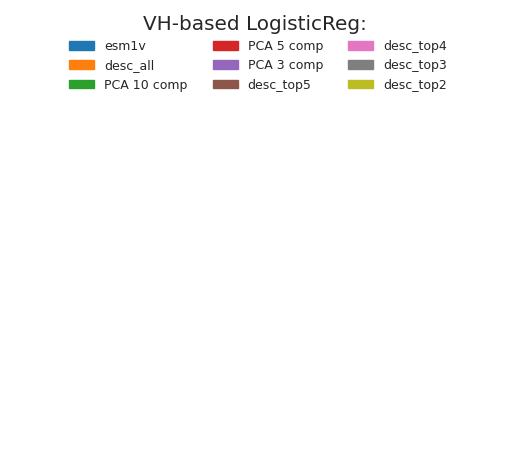

In [14]:
# --- Bar plot of validation performances (k-fold and leave-one-family-out):

font = 16

plt.figure(1)
sns.set_style('ticks')
sns.set_palette(sns.color_palette('tab10'))
s = sns.catplot(x="type", 
                y="accuracy", 
                hue='emd', #"seq", 
                data=table_2classes_concat[(table_2classes_concat['model']=='LogisticReg') &
                                           (table_2classes_concat['emd'].isin(['esm1v','desc_all', 'PCA 10 comp','PCA 5 comp','PCA 3 comp', 'desc_top5', 'desc_top4', 'desc_top3', 'desc_top2'])) &
                                           (table_2classes_concat['seq']=='VH') ],
                kind="bar",
                hue_order=['esm1v','desc_all', 'PCA 10 comp','PCA 5 comp','PCA 3 comp', 'desc_top5', 'desc_top4', 'desc_top3', 'desc_top2'],
                legend=False)


plt.xticks(rotation=30,ha='right',fontsize=font)
plt.yticks([0,0.2,0.4,0.6,0.8,1.0],[0,0.2,0.4,0.6,0.8,1.0])
s.set_yticklabels(size=font)
plt.ylim(0,1)
plt.ylabel('Accuracy',fontsize=font)
plt.xlabel('')
#plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=1, frameon=False, borderaxespad=0.5,fontsize=12)
s.fig.set_figwidth(7) #6
s.fig.set_figheight(5)
plt.tight_layout()
#plt.savefig('./Figures_publication/Bar plots/Fig2_Baseline_models_VH_LogisticReg_accuracy.pdf',dpi=300, bbox_inches='tight')



plt.figure(2)
sns.set_style('ticks')
sns.set_palette(sns.color_palette('tab10'))
s = sns.catplot(x="type", 
                y="sensitivity", 
                hue='emd', #"seq", 
                data=table_2classes_concat[(table_2classes_concat['model']=='LogisticReg') &
                                           (table_2classes_concat['emd'].isin(['esm1v','desc_all', 'PCA 10 comp','PCA 5 comp','PCA 3 comp', 'desc_top5', 'desc_top4', 'desc_top3', 'desc_top2'])) &
                                           (table_2classes_concat['seq']=='VH') ],
                kind="bar",
                hue_order=['esm1v','desc_all', 'PCA 10 comp','PCA 5 comp','PCA 3 comp', 'desc_top5', 'desc_top4', 'desc_top3', 'desc_top2'],
                legend=False)

plt.xticks(rotation=30,ha='right',fontsize=font)
plt.yticks([0,0.2,0.4,0.6,0.8,1.0],[0,0.2,0.4,0.6,0.8,1.0])
s.set_yticklabels(size=font)
plt.ylim(0,1)
plt.ylabel('Sensitivity',fontsize=font) #Sensitivity
plt.xlabel('')
#plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=2, frameon=False, borderaxespad=0.5,fontsize=12)
s.fig.set_figwidth(7) #5
s.fig.set_figheight(5)
plt.tight_layout()
#plt.savefig('./Figures_publication/Bar plots/Fig2_Baseline_models_VH_LogisticReg_sensitivity.pdf',dpi=300, bbox_inches='tight')

plt.figure(3)
sns.set_style('ticks')
sns.set_palette(sns.color_palette('tab10'))
s = sns.catplot(x="type", 
                y="specificity", 
                hue='emd', #"seq", 
                data=table_2classes_concat[(table_2classes_concat['model']=='LogisticReg') &
                                           (table_2classes_concat['emd'].isin(['esm1v','desc_all', 'PCA 10 comp','PCA 5 comp','PCA 3 comp', 'desc_top5', 'desc_top4', 'desc_top3', 'desc_top2'])) &
                                           (table_2classes_concat['seq']=='VH') ],
                kind="bar",
                hue_order=['esm1v','desc_all', 'PCA 10 comp','PCA 5 comp','PCA 3 comp', 'desc_top5', 'desc_top4', 'desc_top3', 'desc_top2'],
                legend=False)

plt.xticks(rotation=30,ha='right',fontsize=font)
plt.yticks([0,0.2,0.4,0.6,0.8,1.0],[0,0.2,0.4,0.6,0.8,1.0])
s.set_yticklabels(size=font)
plt.ylim(0,1)
plt.ylabel('Specificity',fontsize=font)
plt.xlabel('')
s.fig.set_figwidth(7) #5
s.fig.set_figheight(5)
plt.tight_layout()
plt.savefig('./Figures/Fig2C_Baseline_models_VH_LogisticReg_specificity.pdf',dpi=300, bbox_inches='tight')
plt.show()

# --- Save legend separately:

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Define the colors and labels for the legend
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', sns.color_palette()[8]]
labels = ['esm1v','desc_all', 'PCA 10 comp','PCA 5 comp','PCA 3 comp', 'desc_top5', 'desc_top4', 'desc_top3', 'desc_top2']

# Create a legend with the specified colors and labels
legend_patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(labels))]

# Create a separate figure for the legend
fig, ax = plt.subplots()
ax.legend(handles=legend_patches, title='VH-based LogisticReg: ', loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=3, frameon=False, borderaxespad=0.5, fontsize=9)
ax.axis('off')

# Save the legend as a separate file
plt.savefig('./Figures/Fig2C_legend.pdf', bbox_inches='tight')

## (3) Spearman correlation matrix of top 25 descriptors

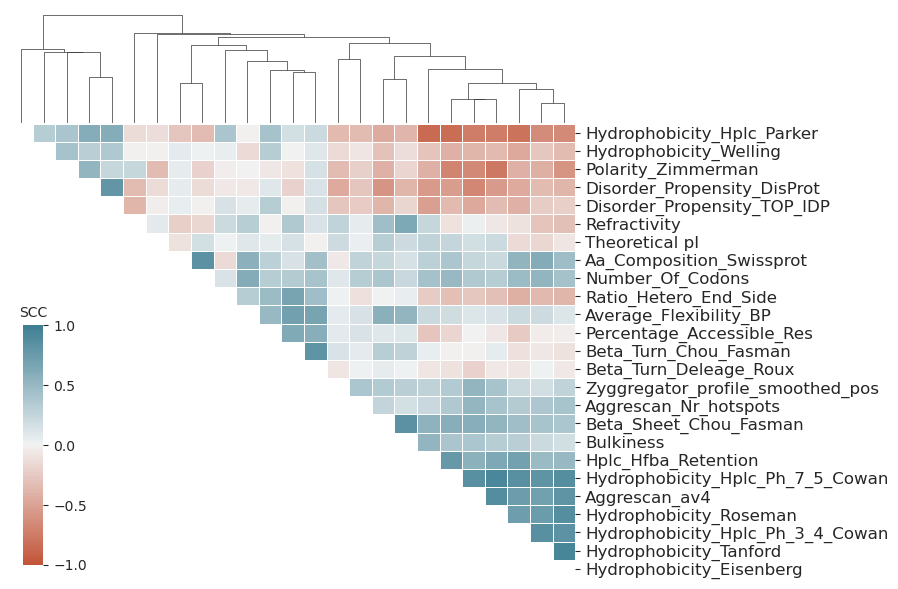

In [18]:
desc_list= ['Disorder_Propensity_DisProt',
            'Disorder_Propensity_TOP_IDP',
            'Theoretical pI',
            'Aggrescan_av4',
            'Percentage_Accessible_Res',
            'Zyggregator_profile_smoothed_pos',
            'Hplc_Hfba_Retention',
            'Hydrophobicity_Tanford',
            'Hydrophobicity_Hplc_Ph_3_4_Cowan',
            'Polarity_Zimmerman',
            'Aggrescan_Nr_hotspots',
            'Hydrophobicity_Hplc_Ph_7_5_Cowan',
            'Beta_Sheet_Chou_Fasman',
            'Hydrophobicity_Welling',
            'Refractivity',
            'Ratio_Hetero_End_Side',
            'Average_Flexibility_BP',
            'Beta_Turn_Chou_Fasman',
            'Hydrophobicity_Hplc_Parker',
            'Hydrophobicity_Roseman',
            'Beta_Turn_Deleage_Roux',
            'Aa_Composition_Swissprot',
            'Hydrophobicity_Eisenberg',
            'Number_Of_Codons',
            'Bulkiness']


Ab_type = 'VH'

# Correlation matrix:
df_corr = dict_desc_Boughter_2classes[Ab_type]
    
# Normalize descriptors:
df_corr_norm = df_corr.copy()
for desc in desc_list:
    desc_i = np.array(df_corr[desc]).reshape(-1, 1)
    scaler = StandardScaler().fit(desc_i) 
    df_corr_norm[desc] = list(scaler.transform(desc_i))

df_corr_norm = df_corr_norm[desc_list].astype(np.float64)


# Calculate pairwise correlations
corr_matrix = df_corr_norm.corr(method='spearman') # 'pearson', 'spearman', 'kendall'

# Re-assemble table:
df_corr_final = pd.DataFrame(corr_matrix).T
df_corr_final['Fragment'] = Ab_type
df_corr_final = df_corr_final.rename_axis('Descriptor').reset_index()
list_order = sum([['Fragment','Descriptor'],desc_list],[])
df_corr_final = df_corr_final[list_order]

# --- Cluster descriptors:
df = corr_matrix.abs()

# Retrieve clusters using fcluster:
d = sch.distance.pdist(df)
L = sch.linkage(d, method='single', metric='euclidean')
clusters = sch.fcluster(L, 0.25*d.max(), 'distance') # 0.23 can be modified to retrieve more stringent or relaxed clusters

corr_matrix['cluster'] = clusters # Add cluster number to df
clust_list = list(Counter(corr_matrix['cluster']).keys())
labels = corr_matrix.pop('cluster') # This one pops out 'cluster' column from df (i.e. removes it).
palette = sns.color_palette('Spectral', len(clust_list))
dict_clust_col = dict(zip(clust_list, palette))
row_colors = labels.map(dict_clust_col)

# Make dictionary for descriptor and cluster number:
dict_desc_cluster = dict(zip(df.columns,clusters))

#plt.figure(1)
g = sns.clustermap(data=corr_matrix, #.abs(),
                   #annot=corr_matrix,
                   xticklabels=False, 
                   yticklabels=True,
                   figsize=(10,6),#(13, 13),
                   vmin=-1, #0 
                   vmax=1, 
                   center=0, #0.5
                   cmap=sns.diverging_palette(20, 220, n=200), 
                   #square=True, 
                   linewidths=.5,
                   cbar_pos=(0.17, 0.05, 0.02, 0.4), #(0.075, 0.87, 0.02, 0.10), #(1, 0.27, 0.02, 0.5),
                   cbar_kws={"ticks":[-1,-0.5,0,0.5,1]},
                   method='single',
                   #row_colors=row_colors,
                   )

mask = np.tril(np.ones_like(corr_matrix))
values = g.ax_heatmap.collections[0].get_array().reshape(corr_matrix.shape)
new_values = np.ma.array(values, mask=mask)
g.ax_heatmap.collections[0].set_array(new_values)
g.ax_row_dendrogram.set_visible(False)

g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 12)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 12)
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), rotation=35, ha='right')
plt.title('SCC', fontsize=10) #Ab_type)
plt.savefig('./Figures/Fig2B_Descriptors_Spearman_corr_matrix_Boughter_2classes_'+str(Ab_type)+'_nonredundant_descriptors.pdf',dpi=300, bbox_inches='tight')
plt.show()

